# Предсказатие оттока клиентов оператора "ТелеДом" 

Данные состоят из нескольких файлов, полученных из разных источников:  
- contract_new.csv — информация о договоре;  
- personal_new.csv — персональные данные клиента;  
- internet_new.csv — информация об интернет-услугах;  
- phone_new.csv — информация об услугах телефонии.  



**Цель работы**

Цель данного проекта заключается в разработке и обучении модели машинного обучения для задачи классификации, которая будет способна предсказывать, уйдет ли клиент от оператора связи "ТелеДом". 
Эта модель будет использовать доступные персональные данные клиентов, информацию о их текущих тарифах и услугах, чтобы предоставить оператору инструмент для предварительной идентификации клиентов, склонных к оттоку. 

Таким образом, основной целью проекта является создание модели, которая поможет оператору связи бороться с оттоком клиентов и эффективно привлекать их обратно с помощью промокодов и специальных предложений, тем самым сохраняя и увеличивая прибыль компании.

**План работы**

1. **Загрузка данных:**   
Загрузка данных и их первичный анализ.  


2. **Анализ и предобработка данных:**   
Анализ данных и их предобработка. Определение полезных признаков для моделирования.  


3. **Объединение данных:**   
Интеграция выбранных признаков в один датасет.  


4. **Анализ и предобработка объединенных данных:**   
Проведение анализа данных после объединения, визуализация распределений признаков и выявление корреляций. Предобработка данных и возможное создание новых признаков.  


5. **Подготовка данных:**   
Подготовка данных для обучения модели, включая разделение данных на обучающую и тестовую выборки, а также масштабирование и кодирование признаков.  


6. **Обучение моделей машинного обучения:**   
Обучение как минимум двух моделей машинного обучения.  
  

7. **Выбор лучшей модели:**   
Выбор лучшей модели и оценка её качества на тестовой выборке.  


8. **Общий вывод и рекомендации.** 

Импортируем необходимые библиотеки.

In [1]:
import os

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import ttest_ind

import phik

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

from sklearn.dummy import DummyClassifier

In [2]:
RANDOM_STATE = 80124

## Загрузка и знакомство с данными

### Договоры

Загрузим файл с данными о договорах клиентов и изучим его.

In [3]:
path = 'contract_new.csv'
url = 'https://code.s3.yandex.net/datasets/contract_new.csv'

if not os.path.isfile(path):
    path = url

In [4]:
contract_df = pd.read_csv(path, index_col='customerID')

Выведем 5 случайных записей. 

In [5]:
contract_df.sample(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
9512-PHSMG,2019-04-01,No,Month-to-month,Yes,Mailed check,20.55,207.56
9798-OPFEM,2016-04-01,No,Two year,Yes,Electronic check,21.10,970.6
2115-BFTIW,2017-12-01,2018-10-01,Month-to-month,No,Mailed check,70.95,709.5
1257-SXUXQ,2019-09-01,No,Month-to-month,No,Mailed check,19.45,100.17
1324-NLTJE,2018-07-01,2019-11-01,Month-to-month,No,Credit card (automatic),55.00,880.0


In [6]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


Датафрейм содержит 7043 записи и 7 столбцов.

Приведем названия столбцов к змеиному регистру. 

In [7]:
replace_col_names = {
    'BeginDate' : 'begin_date',
    'EndDate' : 'end_date',
    'Type' : 'type',
    'PaperlessBilling' : 'paperless_billing',
    'PaymentMethod' : 'payment_method',
    'MonthlyCharges' : 'monthly_charges',
    'TotalCharges' : 'total_charges'
}

In [8]:
contract_df.index.rename('customer_id', inplace=True)

In [9]:
contract_df = contract_df.rename(columns=replace_col_names)

Приведем столбцы к корректным типам данных. 

In [10]:
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'], errors='coerce', format='%Y-%m-%d')
contract_df['end_date'] = pd.to_datetime(contract_df['end_date'], errors='coerce', format='%Y-%m-%d')
contract_df['total_charges'] = pd.to_numeric(contract_df['total_charges'], errors='coerce')
contract_df['paperless_billing'] = contract_df['paperless_billing'].map({'Yes': 1, 'No': 0}).astype(str)

In [11]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 440.2+ KB


После приведения столбцов к корректному типу данных появились пропуски. Изучим их. 

In [12]:
contract_df.isna().sum()

begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
dtype: int64

In [13]:
contract_df.query('total_charges.isna()')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,NaN
5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,NaN
4367-NUYAO,2020-02-01,NaT,Two year,0,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,NaT,Two year,0,Credit card (automatic),56.05,NaN
7644-OMVMY,2020-02-01,NaT,Two year,0,Mailed check,19.85,NaN
3213-VVOLG,2020-02-01,NaT,Two year,0,Mailed check,25.35,NaN
2520-SGTTA,2020-02-01,NaT,Two year,0,Mailed check,20.00,NaN
2923-ARZLG,2020-02-01,NaT,One year,1,Mailed check,19.70,NaN


Пропуски в столбце `total_charges` связаны с тем, что клиенты только что оформили свои договоры (дата начала договора равна дате актуальности данных), заменим пропуски в колонке на 0, оплата еще не производилась. 

In [14]:
contract_df['total_charges'].fillna(0, inplace=True)

Изучим пропуски в колонке `end_date`. 

In [15]:
contract_df.query('end_date.isna()').sample(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
3981-QSVQI,2019-06-01,NaT,Month-to-month,1,Bank transfer (automatic),19.70,159.18
8295-FHIVV,2019-07-01,NaT,Month-to-month,1,Mailed check,19.40,139.87
1996-DBMUS,2016-02-01,NaT,Month-to-month,1,Bank transfer (automatic),70.65,3492.94
4115-BNPJY,2017-09-01,NaT,Two year,0,Mailed check,75.55,2190.95
4801-JZAZL,2019-03-01,NaT,Month-to-month,1,Electronic check,29.60,325.60
6265-FRMTQ,2017-07-01,NaT,Two year,0,Bank transfer (automatic),20.40,657.70
4525-VZCZG,2015-08-01,NaT,One year,1,Electronic check,105.85,5715.90
2001-MCUUW,2016-04-01,NaT,Two year,0,Electronic check,108.65,4997.90
0212-ISBBF,2018-04-01,NaT,Month-to-month,1,Electronic check,50.35,1196.32


Пропуски в данной колонке связаны с тем, что клиент не расторг договор и продолжает пользоваться услугами компании. 
Основываясь на информации о дате начала и дате окончания договора, создадим два новых столбца - "продолжительность действия договора клиента в днях" и "факт ухода клиента". 

Для клиентов, которые не расторгали договор, будем считать продолжительность между датой актуальности данных и датой начала договора. 

In [16]:
curr_date = pd.to_datetime('2020-02-02', format='%Y-%m-%d')

def calculate_duration(row):
    end_date = row['end_date'] if pd.notna(row['end_date']) else curr_date
    return (end_date - row['begin_date']).days

In [17]:
contract_df['duration'] = contract_df.apply(calculate_duration, axis=1)

In [18]:
contract_df['terminated'] = contract_df['end_date'].notna().astype(int)

Изучим данные после добавления новых столбцов. 

In [19]:
contract_df.sample(5)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,terminated
customer_id,,,,,,,,,
0602-DDUML,2015-05-01,2019-06-01,Two year,0,Mailed check,69.75,3725.35,1492,1
4685-ERGHK,2015-05-01,NaT,One year,1,Electronic check,86.90,4953.30,1738,0
6992-TKNYO,2016-12-01,NaT,One year,0,Credit card (automatic),69.00,2884.20,1158,0
4391-RESHN,2017-12-01,NaT,Month-to-month,1,Mailed check,104.05,2705.30,793,0
0562-KBDVM,2014-04-01,2018-07-01,Two year,1,Bank transfer (automatic),44.60,2502.06,1552,1


### Персональные данные клиентов

Загрузим файл с данными о договорах клиентов и изучим его.

In [20]:
path = 'personal_new.csv'
url = 'https://code.s3.yandex.net/datasets/personal_new.csv'

if not os.path.isfile(path):
    path = url

In [21]:
persons_df = pd.read_csv(path, index_col='customerID')

Выведем 5 случайных записей. 

In [22]:
persons_df.sample(5)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
6728-DKUCO,Female,0,Yes,Yes
8387-UGUSU,Female,0,Yes,Yes
4581-SSPWD,Female,0,No,No
2405-LBMUW,Female,0,Yes,Yes
1766-GKNMI,Male,0,No,No


In [23]:
persons_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


Датафрейм содержит 7043 записи и имеет 4 столбца.

Приведем названия столбцов к змеиному регистру. 

In [24]:
replace_col_names = {
    'SeniorCitizen' : 'senior_citizen',
    'Partner' : 'partner',
    'Dependents' : 'dependents'
}

In [25]:
persons_df.index.rename('customer_id', inplace=True)

In [26]:
persons_df.rename(columns=replace_col_names, inplace=True)

Приведем столбцы к корректным типам данных. 

In [27]:
persons_df['partner'] = persons_df['partner'].map({'Yes': 1, 'No': 0}).astype(str)
persons_df['dependents'] = persons_df['dependents'].map({'Yes': 1, 'No': 0}).astype(str)
persons_df['senior_citizen'] = persons_df['senior_citizen'].astype(str)

In [28]:
persons_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   object
 1   senior_citizen  7043 non-null   object
 2   partner         7043 non-null   object
 3   dependents      7043 non-null   object
dtypes: object(4)
memory usage: 275.1+ KB


In [29]:
persons_df.sample(5)

,gender,senior_citizen,partner,dependents
customer_id,,,,
0756-MPZRL,Male,0,0,0
5171-EPLKN,Male,0,0,0
9479-HYNYL,Female,0,1,0
3584-WKTTW,Male,0,1,0
6261-LHRTG,Female,0,0,0


### Интернет-услуги

Загрузим файл с данными об интернет-услугах и изучим его.

In [30]:
path = 'internet_new.csv'
url = 'https://code.s3.yandex.net/datasets/internet_new.csv'

if not os.path.isfile(path):
    path = url

In [31]:
internet_df = pd.read_csv(path, index_col='customerID')

Выведем 5 случайных записей. 

In [32]:
internet_df.sample(5)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
6516-NKQBO,DSL,Yes,No,Yes,Yes,Yes,Yes
4250-ZBWLV,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
0897-FEGMU,Fiber optic,No,No,Yes,No,Yes,Yes
0674-DGMAQ,Fiber optic,No,Yes,Yes,No,No,Yes
7148-XZPHA,Fiber optic,No,Yes,No,Yes,No,No


In [33]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


Датафрейм содержит 5517 записей и имеет 7 столбцов.

Приведем названия столбцов к змеиному регистру. 

In [34]:
replace_col_names = {
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies'
}

In [35]:
internet_df.index.rename('customer_id', inplace=True)

In [36]:
internet_df.rename(columns=replace_col_names, inplace=True)

Приведем столбцы, показывающие использование определенной услуги, к корректному типу.

In [37]:
services = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

for col in services:
    internet_df[col] = internet_df[col].map({'Yes': 1, 'No': 0}).astype(int)

In [38]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   int32 
 2   online_backup      5517 non-null   int32 
 3   device_protection  5517 non-null   int32 
 4   tech_support       5517 non-null   int32 
 5   streaming_tv       5517 non-null   int32 
 6   streaming_movies   5517 non-null   int32 
dtypes: int32(6), object(1)
memory usage: 215.5+ KB


In [39]:
internet_df.sample(5)

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customer_id,,,,,,,
9097-ZUBYC,DSL,0,0,0,1,0,0
0817-HSUSE,DSL,0,0,1,1,1,1
1343-EHPYB,Fiber optic,0,1,1,0,1,1
5832-EXGTT,DSL,1,0,0,0,0,1
3043-TYBNO,DSL,0,0,0,1,0,1


### Услуги телефонии

Загрузим файл с данными об интернет-услугах и изучим его.

In [40]:
path = 'phone_new.csv'
url = 'https://code.s3.yandex.net/datasets/phone_new.csv'

if not os.path.isfile(path):
    path = url

In [41]:
phone_df = pd.read_csv(path, index_col='customerID')

Выведем 5 случайных записей. 

In [42]:
phone_df.sample(5)

,MultipleLines
customerID,
2097-YVPKN,Yes
1867-TJHTS,Yes
4423-YLHDV,Yes
5299-RULOA,Yes
7607-QKKTJ,Yes


In [43]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Датафрейм содержит 6361 запись и имеет 1 столбец.

Приведем названия столбцов к змеиному регистру.

In [44]:
replace_col_names = {
    'MultipleLines': 'multiple_lines'
}

In [45]:
phone_df.index.rename('customer_id', inplace=True)

In [46]:
phone_df.rename(columns=replace_col_names, inplace=True)

Приведем столбец к корректному типу.

In [47]:
phone_df['multiple_lines'] = phone_df['multiple_lines'].map({'Yes': 1, 'No': 0}).astype(str)

In [48]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   multiple_lines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [49]:
phone_df.sample(5)

,multiple_lines
customer_id,
7216-EWTRS,1
7693-QPEFS,1
3278-FSIXX,0
9917-KWRBE,1
0958-YHXGP,0


## Исследовательский анализ данных

На данном этапе проведем исследовательский анализ данных из каждого датафрейма. 

### Договоры

In [50]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   duration           7043 non-null   int64         
 8   terminated         7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(3)
memory usage: 522.7+ KB


#### Дата начала действия договора 

Проанализируем временной ряд даты начала действия договора. Для этого сгруппируем данные по дате начала договора и разложим ряд на составляющие - тренд, сезонность и остатки декомпозиции. 

In [51]:
time_series = contract_df.groupby('begin_date').size()
time_series.index = pd.to_datetime(time_series.index)
time_series.sort_index(inplace=True)

decomposed = seasonal_decompose(time_series)

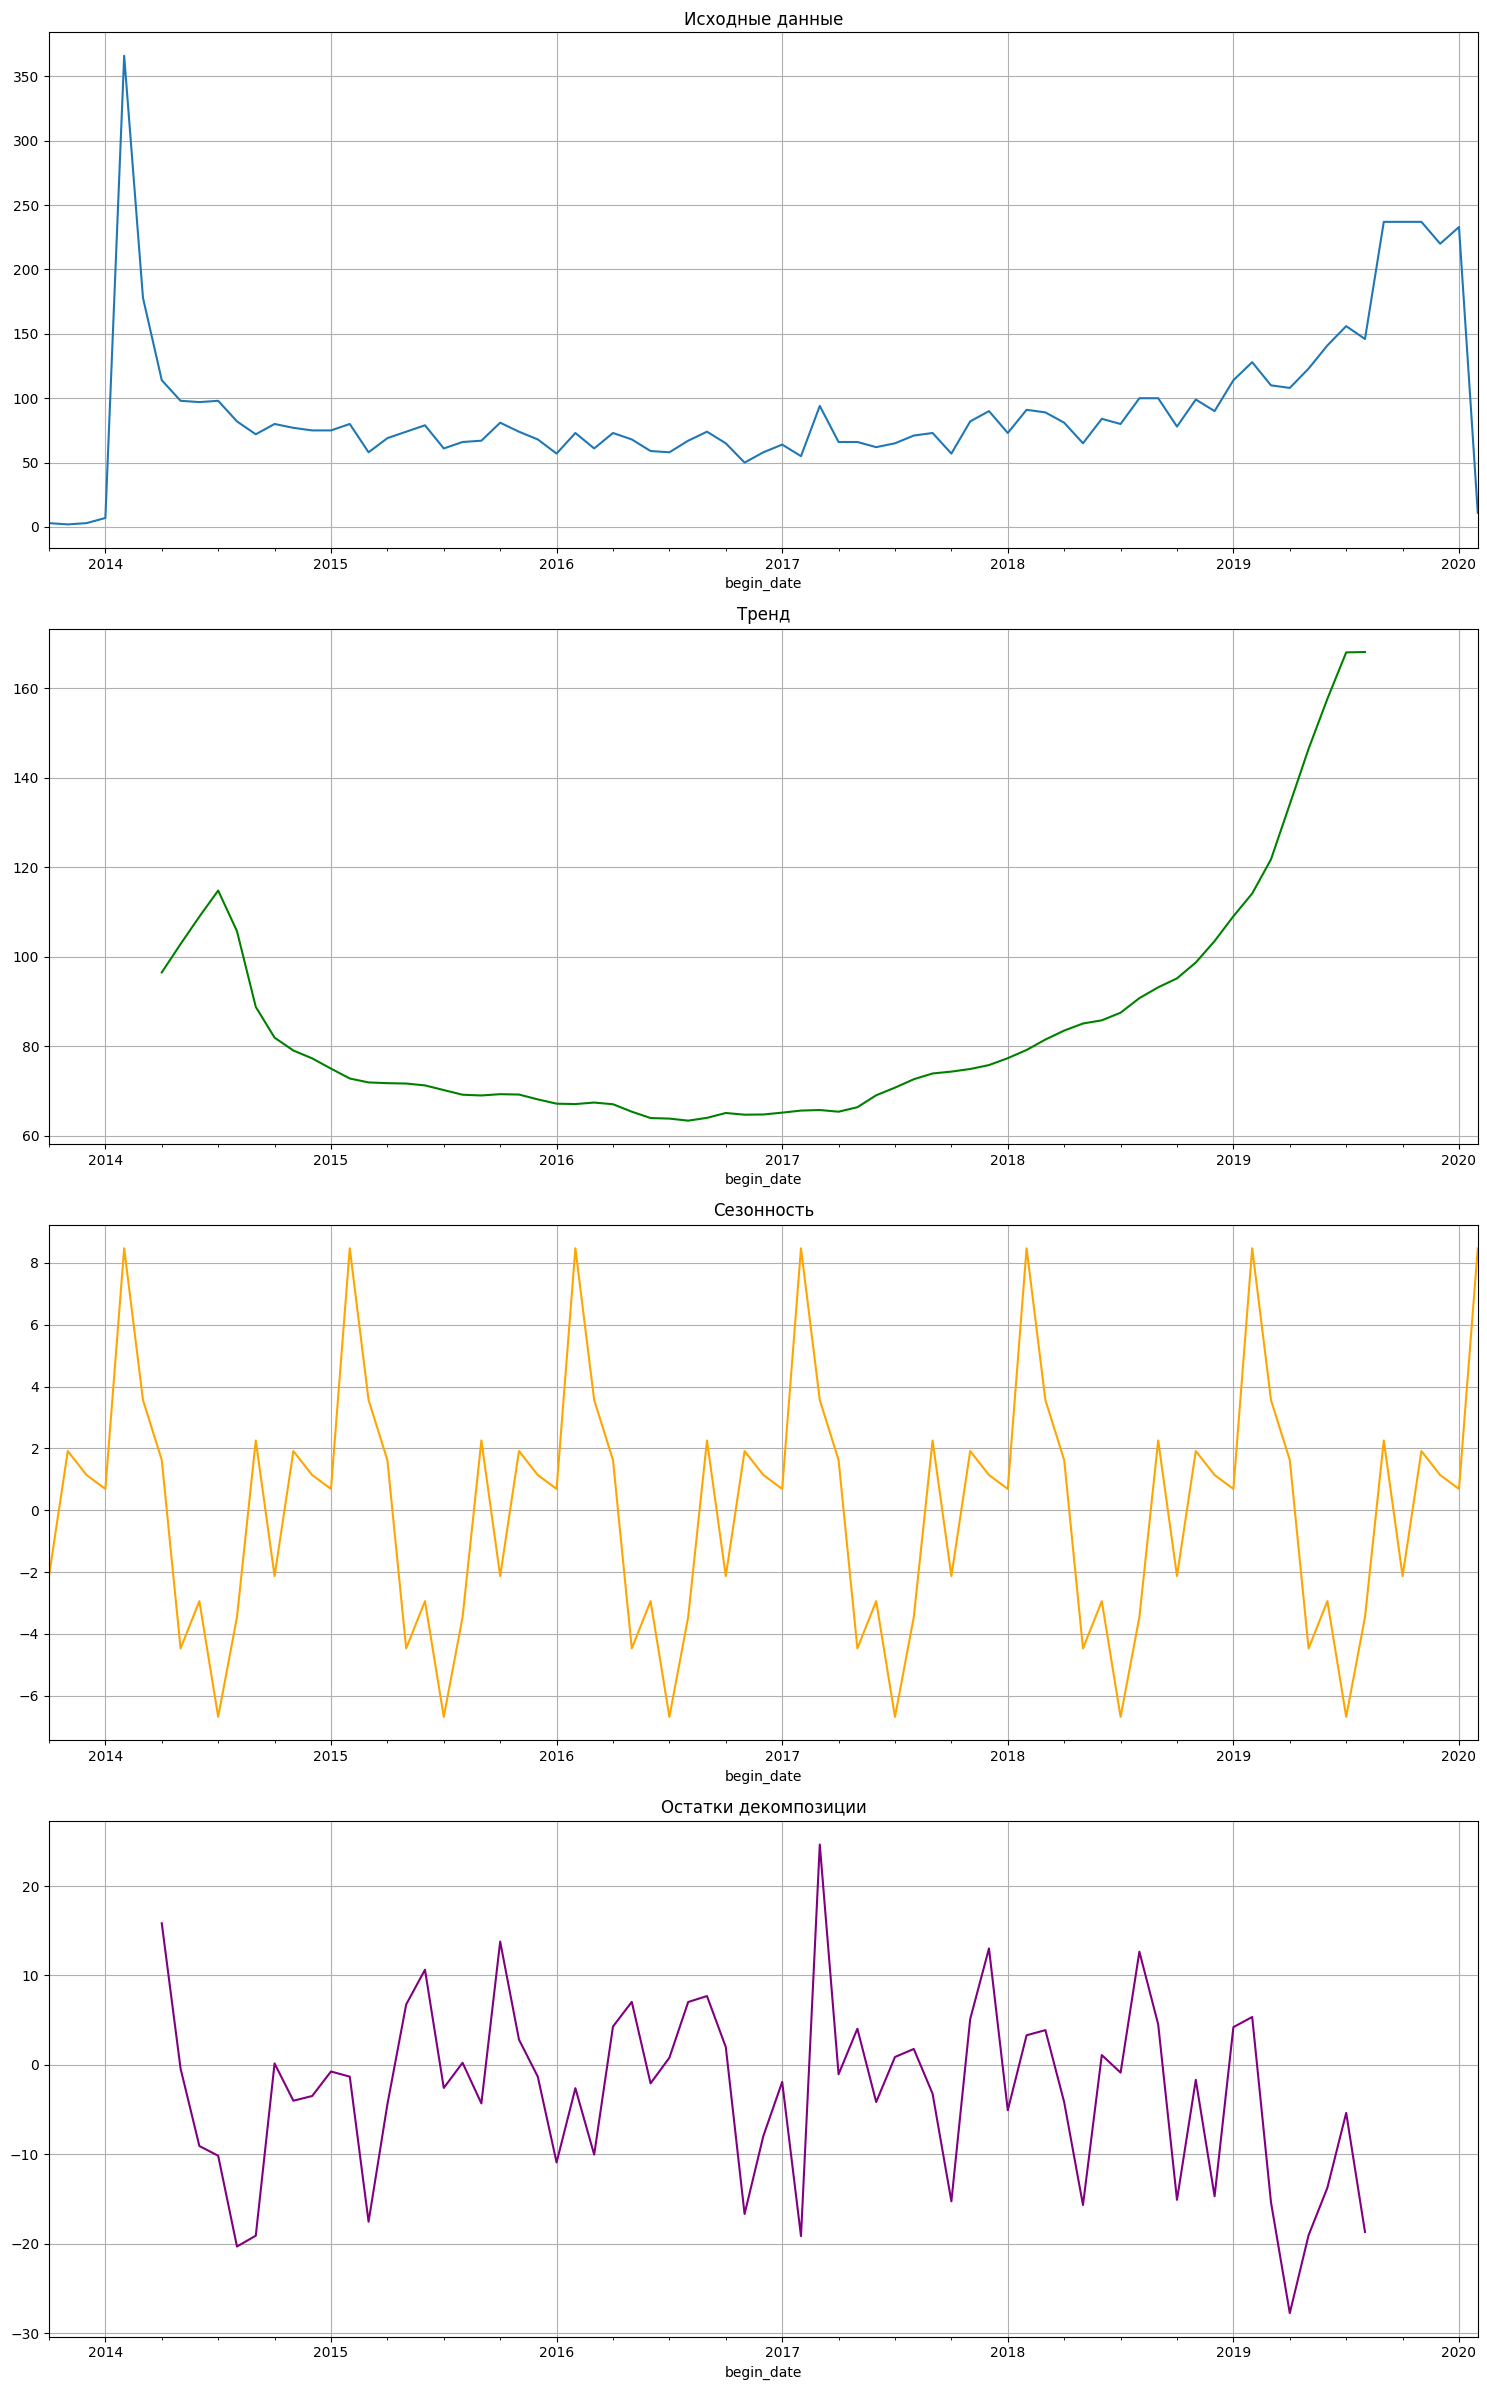

In [52]:
plt.figure(figsize=(15, 6*4))

plt.subplot(4, 1, 1)
decomposed.observed.plot(ax=plt.gca())
plt.title('Исходные данные')
plt.grid(True)

plt.subplot(4, 1, 2)
decomposed.trend.plot(ax=plt.gca(), color='green')
plt.title('Тренд')
plt.grid(True)

plt.subplot(4, 1, 3)
decomposed.seasonal.plot(ax=plt.gca(), color='orange')
plt.title('Сезонность')
plt.grid(True)

plt.subplot(4, 1, 4)
decomposed.resid.plot(ax=plt.gca(), color='purple')
plt.title('Остатки декомпозиции')
plt.grid(True)

plt.tight_layout()
plt.show()

Глядя на графики, можно сделать следующие выводы: 
1. **Исходные данные**: График показывает общее количество заключенных договоров во времени. На графике видно, что в начале периода есть пик, который возможно вызван акцией, которая привлекла большое количество клиентов. После пика наблюдается резкое снижение, и в последующем количество новых договоров стабилизируется, но с некоторыми колебаниями в течение всего периода. В конце периода виден значительный рост количества новых договоров.
2. **Тренд**: Здесь виден тренд сначала на уменьшение количества новых договоров, который затем сменяется постепенным и устойчивым ростом, начиная примерно с 2018 года. У бизнеса произошли положительные изменение, количество клиентов стало расти. 
3. **Сезонность**: На графике видны регулярные колебания, что может указывать на сезонные эффекты.

Изучим сезонность, изменив масштаб. Посмотрим график сезонности, ограничив период одним годом. 

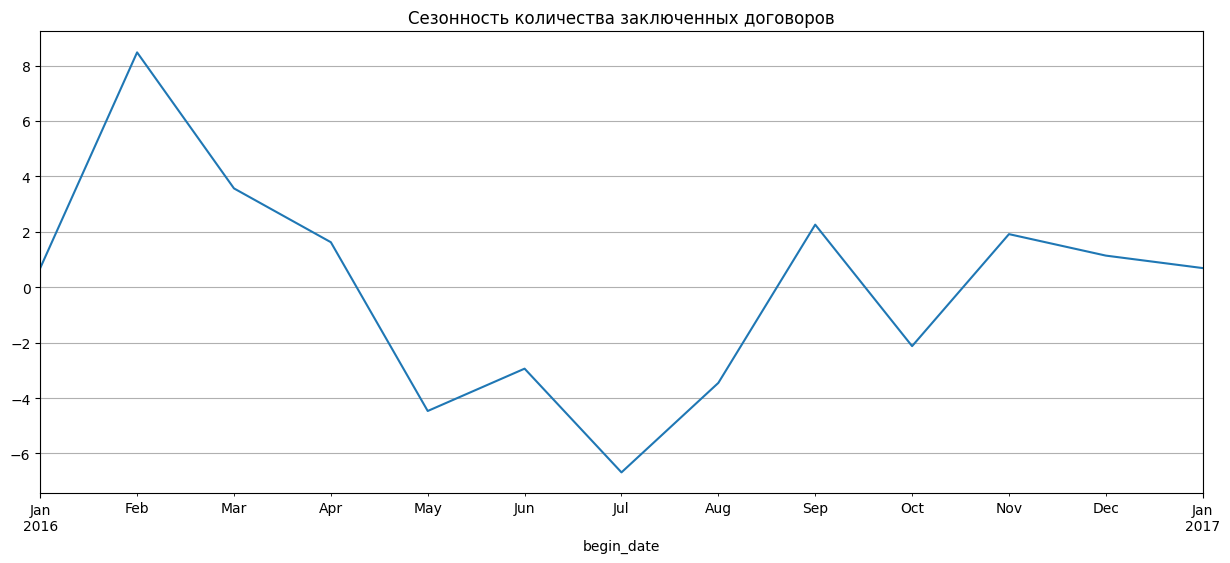

In [53]:
decomposed.seasonal['2016-01-01' : '2017-01-01'].plot(figsize=(15,6))
plt.title('Сезонность количества заключенных договоров')
plt.grid(True)

На увеличенном графике сезонности видны следующие особенности: 

1. Пик в начале года: Наблюдается ярко выраженный пик в феврале, который может указывать на сезонное увеличение числа заключенных договоров, возможно, из-за специальных предложений или маркетинговых акций.

2. Спад весной: После февральского пика следует снижение количества новых договоров в марте и апреле, что может свидетельствовать о сезонном спаде интереса к услугам или окончании акционного периода.

3. Летние колебания: В летние месяцы график имеет колебания, видны взлеты и падения.

4. Подъем к концу года: В октябре и ноябре наблюдается возрастание количества заключенных договоров.

5. Уменьшение активности в конце года: В декабре виден небольшой спад в количестве приходящих клиентов. 

Теперь изучим, как дата прихода клиента влияет на факт расторженности договора. Для этого отобразим долю расторгнутых договоров с течением времени. 

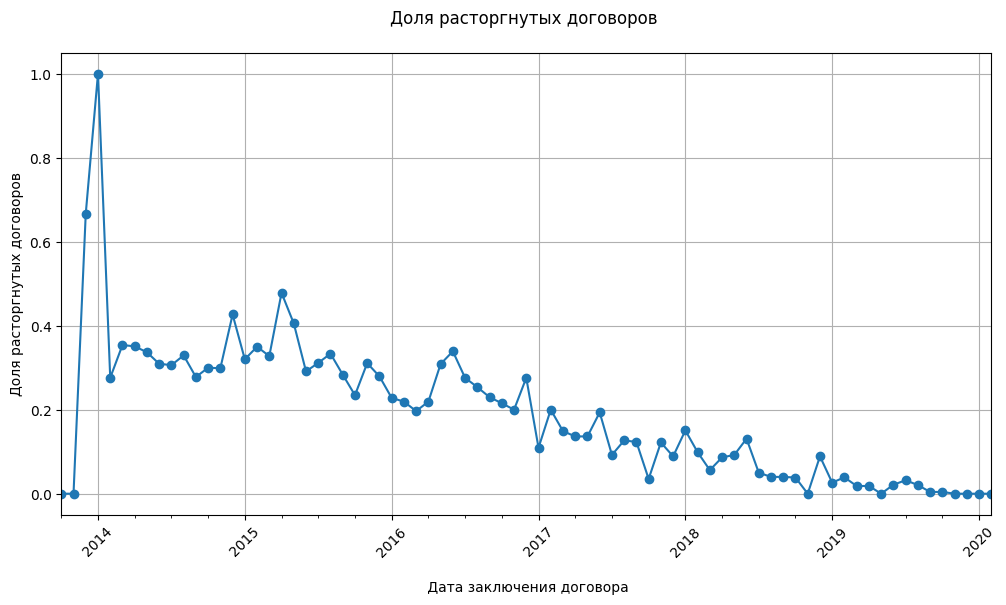

In [54]:
plt.figure(figsize=(12, 6))
contract_df.groupby('begin_date')['terminated'].mean().plot(marker='o')
plt.title('Доля расторгнутых договоров \n')
plt.xlabel('\n Дата заключения договора')
plt.ylabel('Доля расторгнутых договоров')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

В начале временного периода виден резкий всплеск до 1, что может указывать на высокую долю расторгнутых договоров относительно небольшого числа заключенных в начальный период работы компании. Затем следует постепенное снижение этой доли, что может быть результатом стабилизации бизнес-процессов или улучшения условий договоров.

На протяжении последующих лет наблюдается некоторая волатильность в доле расторгнутых договоров, с периодическими взлетами и падениями, но общая тенденция указывает на уменьшение этой доли со временем. К 2020 году доля расторгнутых договоров значительно уменьшилась и стала практически равной нулю. 

Таким образом, можно сказать, что клиенты, пришедшие позже, реже расторгают договоры. Доля расторжений среди давних клиентов намного выше. 

#### Дата окончания действия договора

По аналогии с временным рядом с датой начала договора изучим временной ряд даты окончания и количества расторгнутых договоров. 

In [55]:
time_series = contract_df.groupby('end_date').size()
time_series.index = pd.to_datetime(time_series.index)
time_series.sort_index(inplace=True)
time_series = time_series.resample('M').sum()
time_series = time_series.fillna(0)

decomposed = seasonal_decompose(time_series)

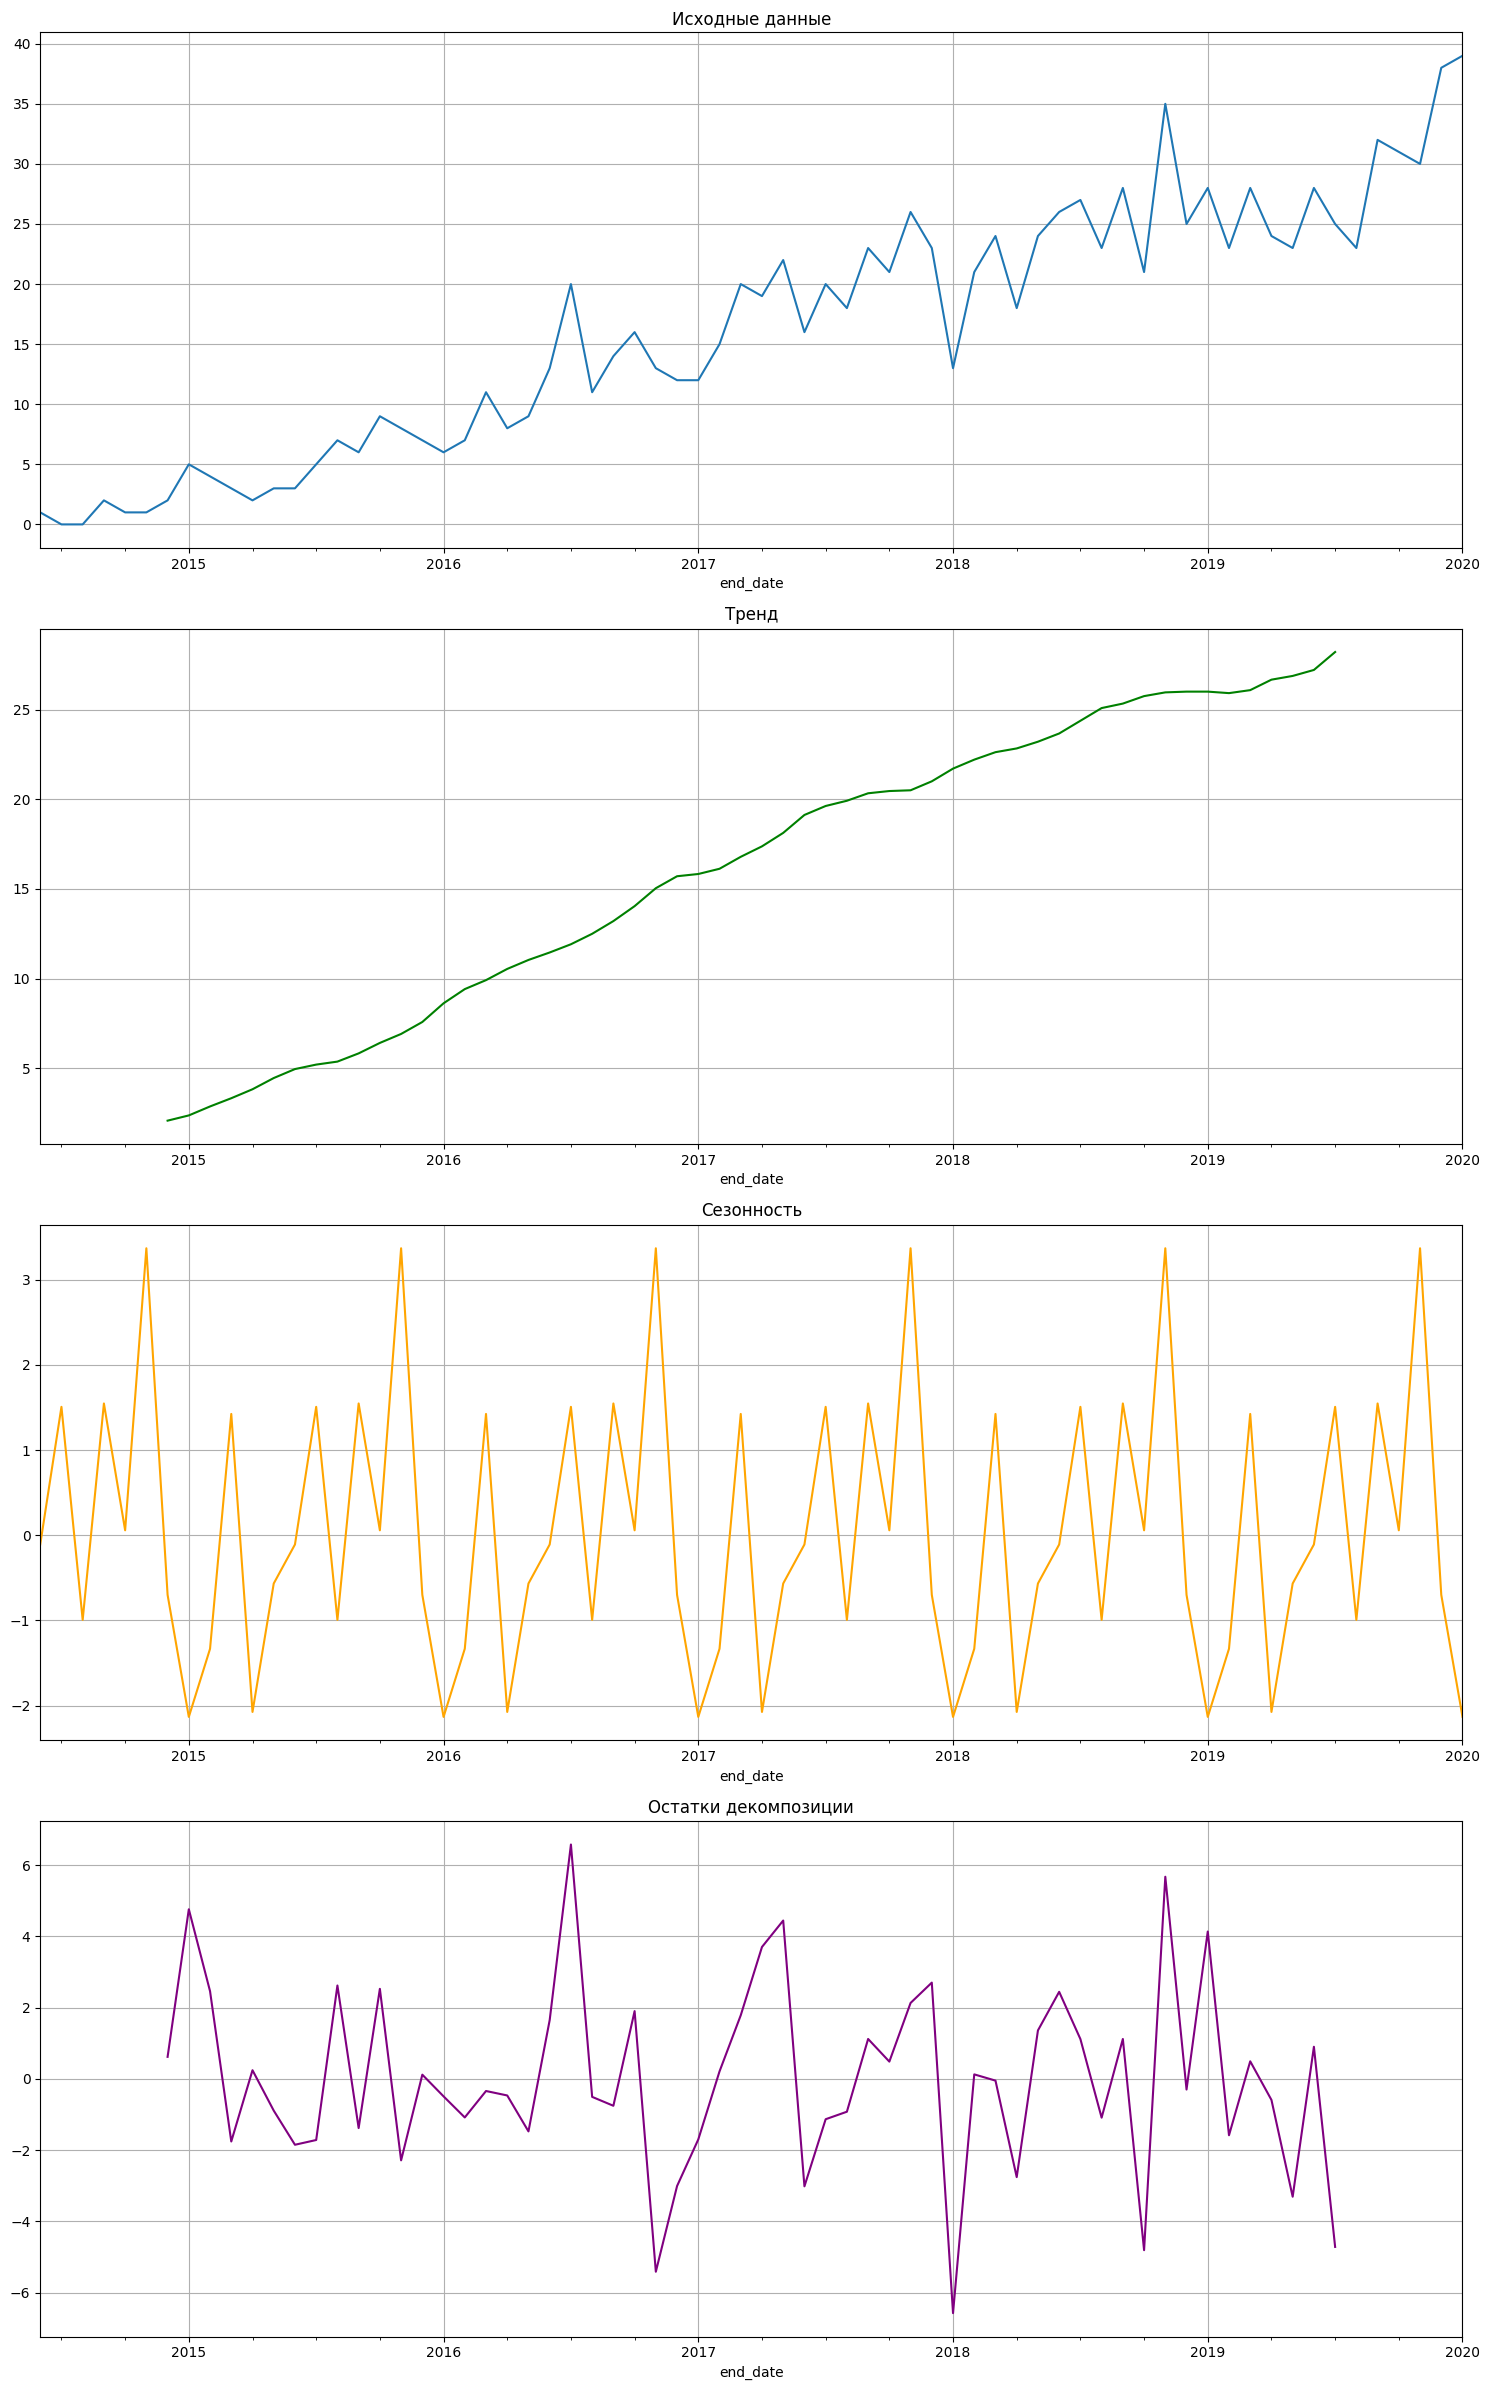

In [56]:
plt.figure(figsize=(15, 6*4))

plt.subplot(4, 1, 1)
decomposed.observed.plot(ax=plt.gca())
plt.title('Исходные данные')
plt.grid(True)

plt.subplot(4, 1, 2)
decomposed.trend.plot(ax=plt.gca(), color='green')
plt.title('Тренд')
plt.grid(True)

plt.subplot(4, 1, 3)
decomposed.seasonal.plot(ax=plt.gca(), color='orange')
plt.title('Сезонность')
plt.grid(True)

plt.subplot(4, 1, 4)
decomposed.resid.plot(ax=plt.gca(), color='purple')
plt.title('Остатки декомпозиции')
plt.grid(True)

plt.tight_layout()
plt.show()

Глядя на графики, можно сделать следующие выводы: 
1. **Исходные данные**: Этот график показывает исходный временной ряд количества расторгнутых договоров. Виден общий тренд на увеличение количества расторгнутых договоров со временем. Однако нельзя точно сказать, что клиенты начали чаще уходить, т.к. количество клиентов со временем также растет. 
2. **Тренд**: Наблюдается стабильный рост количества расторгнутых договоров на протяжении всего периода. 
3. **Сезонность**: Можно увидеть, что есть определенные временные периоды, когда расторжения договоров происходят чаще. 

Изучим сезонность, изменив масштаб. Посмотрим график сезонности, ограничив период одним годом. 

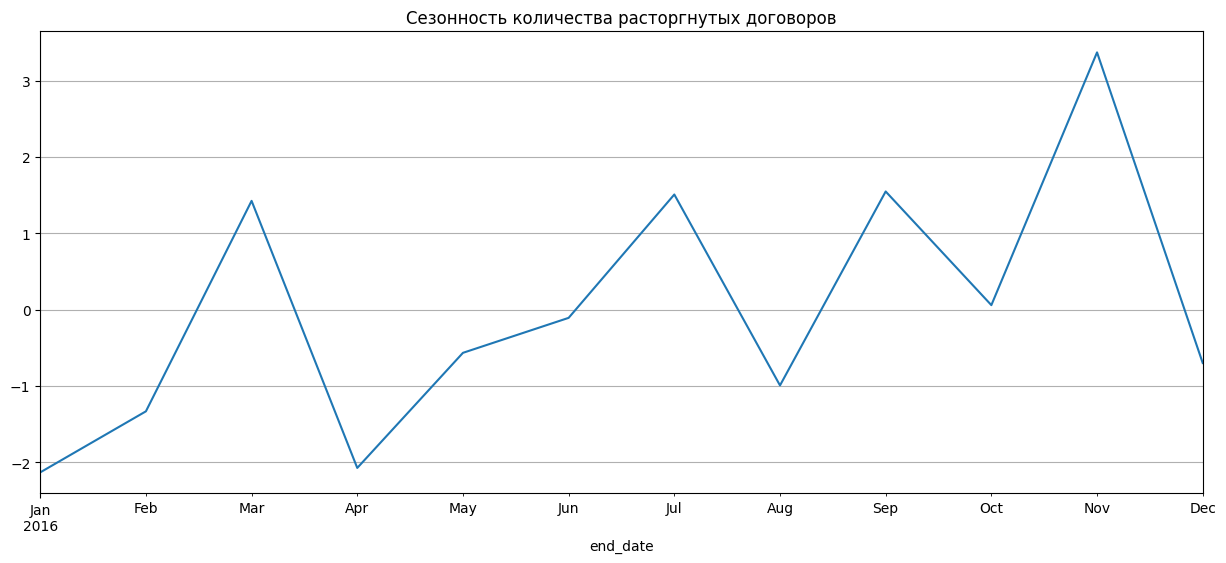

In [57]:
decomposed.seasonal['2016-01-01' : '2017-01-01'].plot(figsize=(15,6))
plt.title('Сезонность количества расторгнутых договоров')
plt.grid(True)

На увеличенном графике сезонности видны следующие особенности:

1. Пики в марте, июле и сентябре: Существуют пики в марте, июле и сентябре, которые могут свидетельствовать о сезонном увеличении числа расторгнутых договоров.
2. Впадины в апреле и августе: Наблюдаются спады в апреле и августе, что может указывать на периоды более низкой активности расторжения договоров.
3. Регулярные восходящие и нисходящие тренды: В течение года видны регулярные восходящие и нисходящие тренды.
4. Повышение активности к концу года: К концу года, в ноябре, наблюдается еще один пик, что может быть связано с сезонными маркетинговыми и рекламными кампаниями, которые могут повышать склонность клиентов к смене оператора для получения более выгодных условий.

#### Длительность договора

Изучим данные о длительности клиентских договоров в днях. 

Для начала построим гистограмму длительности для действующих и ушедших клиентов. 

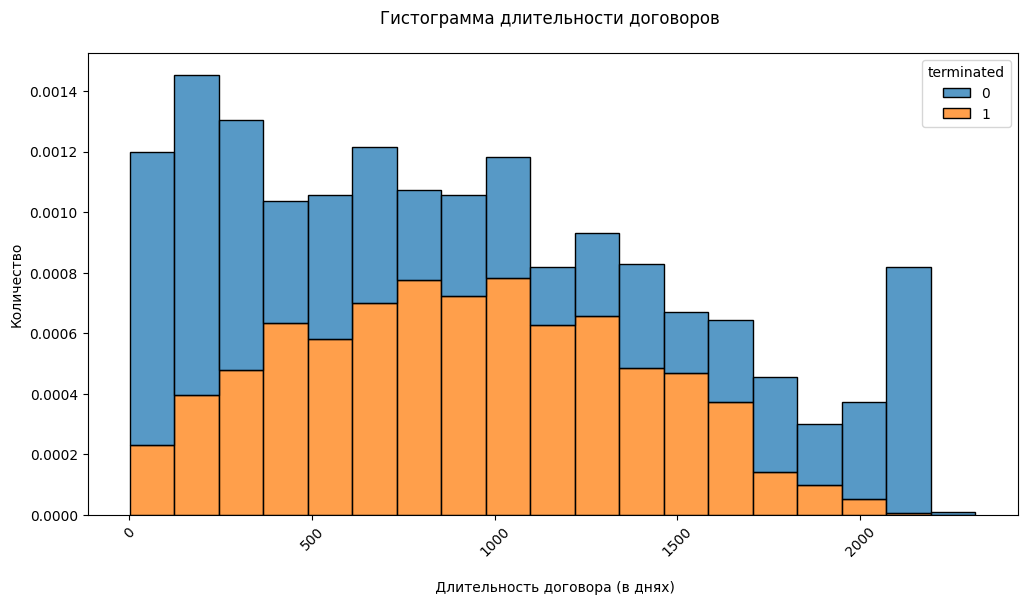

In [58]:
plt.figure(figsize=(12, 6))
sns.histplot(data=contract_df, x='duration', hue='terminated', multiple='stack', stat='density', common_norm=False)
plt.title('Гистограмма длительности договоров \n')
plt.xlabel('\n Длительность договора (в днях)')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

В распределении продолжительности расторгнутых и нерасторгнутых договоров видны отличия. Опишем их: 

1. Большинство нерасторгнутых договоров имеет относительно небольшую продолжительность, однако в правом конце гистограммы есть пик, который показывает, что также существует достаточное количество клиентов, использующих услуги оператора уже очень продолжительное время.
2. Распределение продолжительности расторгнутых договоров в свою очередь имеет распределение, похожее на нормальное - малое количество коротких и длинных договоров, большинство имеет продолжительность 400-1300 дней. 
3. Клиенты, расторгнувшие свой договор, редко уходили на ранних этапах и еще реже, когда они пользовались услугами более 4.5 лет. 

Изучим статистики для актуальных и расторгнутых договоров. 

In [59]:
contract_df.groupby('terminated')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
terminated,,,,,,,,
0,5942.0,894.681084,716.958551,1.0,246.0,703.0,1524.0,2315.0
1,1101.0,924.863760,458.771309,28.0,577.0,915.0,1249.0,2129.0


Построим диаграмму размаха продолжительности договора в разрезе факта ухода клиента. 

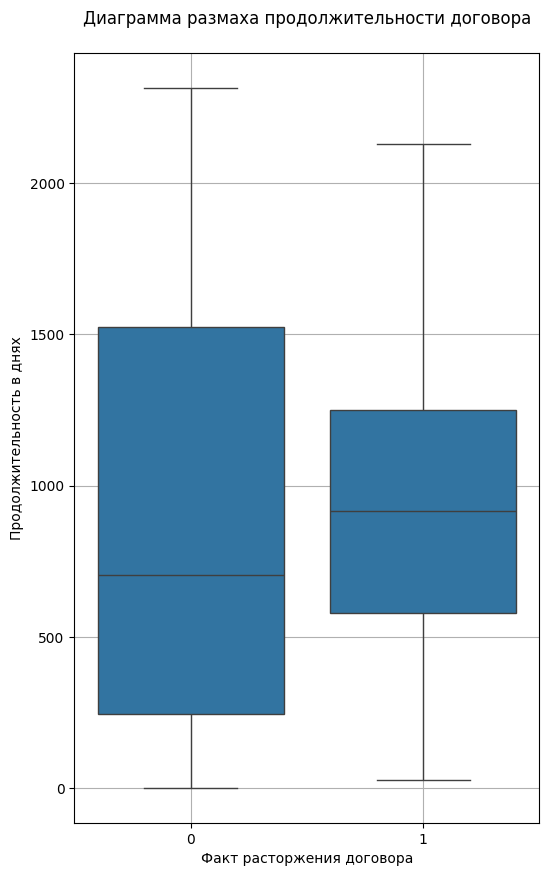

In [60]:
plt.figure(figsize=(6, 10))
sns.boxplot(x='terminated', y='duration', data=contract_df)
plt.title('Диаграмма размаха продолжительности договора\n')
plt.ylabel('Продолжительность в днях')
plt.xlabel('Факт расторжения договора')
plt.grid(True)
plt.show()

На диаграмме видно, что размах продолжительности у оставшихся клиентов больше, а медиана меньше.  

Проведем t-тест для проверки гипотезы о том, что средние продолжительности действия договора у ушедших и оставшихся клиентов равны. 

In [61]:
terminated = contract_df[contract_df['terminated'] == 1]['duration']
not_terminated = contract_df[contract_df['terminated'] == 0]['duration']

In [62]:
results = ttest_ind(terminated, not_terminated, equal_var=False)

alpha = 0.05 

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Средние продолжительности договоров для оставшихся и ушедших клиентов не равны.')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.07022741446900888
Не получилось отвергнуть нулевую гипотезу


Поскольку p-value выше alpha, нулевая гипотеза о равенстве средних не отвергается. Это означает, что нет достаточных статистических доказательств, чтобы утверждать, что средняя длительность договоров для клиентов, расторгших и не расторгших договор, различается.

#### Расторгнутые договоры

Изучим, как распределены наши данные в разрезе факта ухода клиента. 

In [63]:
terminated_counts = contract_df['terminated'].value_counts()

In [64]:
terminated_counts

terminated
0    5942
1    1101
Name: count, dtype: int64

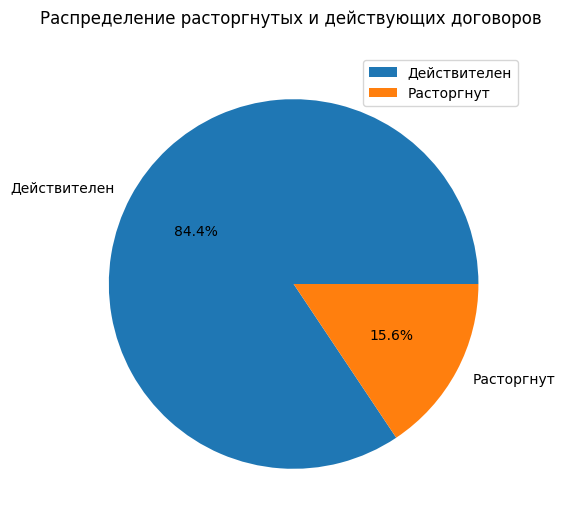

In [65]:
plt.figure(figsize=(6, 6))
plt.pie(terminated_counts, labels=['Действителен', 'Расторгнут'], autopct='%1.1f%%')
plt.title('Распределение расторгнутых и действующих договоров \n')
plt.legend(loc='upper right')
plt.show()

Большая часть клиентов продолжают пользоваться услугами оператора (84.4%), и только 15.6% расторгли договор. 

#### Тип платежа

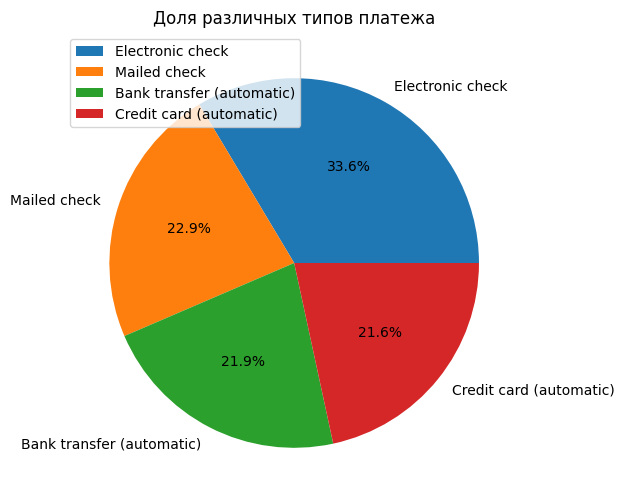

In [66]:
payment_method_counts = contract_df['payment_method'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(payment_method_counts, labels=payment_method_counts.index, autopct='%1.1f%%')
plt.title('Доля различных типов платежа')
plt.legend(loc='upper left')
plt.show()

Из этой диаграммы видно, что электронные чеки являются наиболее популярным методом платежа среди представленных, а автоматические банковские переводы - наименее популярным. 

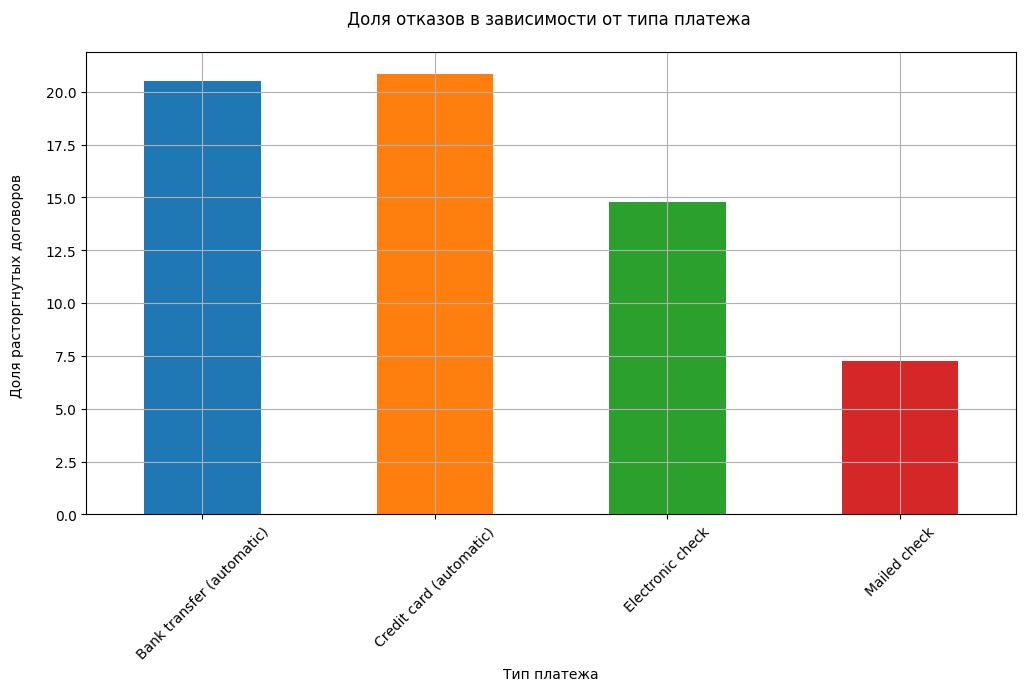

In [67]:
plt.figure(figsize=(12, 6))
(contract_df.groupby('payment_method')['terminated'].mean() * 100).plot.bar(color=['C0','C1','C2','C3'])
plt.title('Доля отказов в зависимости от типа платежа \n')
plt.xlabel('Тип платежа')
plt.ylabel('Доля расторгнутых договоров \n')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Почтовые чеки имеют самую низкую вероятность ухода клиента, в то время как автоматическая оплата по банковской карте - самую высокую.

#### Тип оплаты

Изучим, как распределены типы оплаты. 

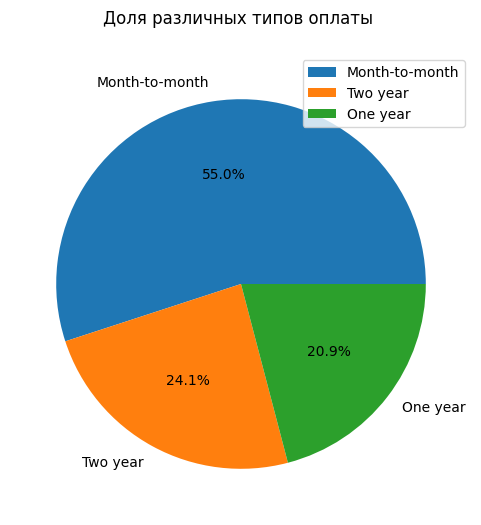

In [68]:
payment_type_counts = contract_df['type'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(payment_type_counts, labels=payment_type_counts.index, autopct='%1.1f%%')
plt.title('Доля различных типов оплаты \n')
plt.legend(loc='upper right')
plt.show()

Большинство клиентов предпочитают оплату по месячной системе (55%), наименьшее число (20.9%) - ежегодную оплату. 

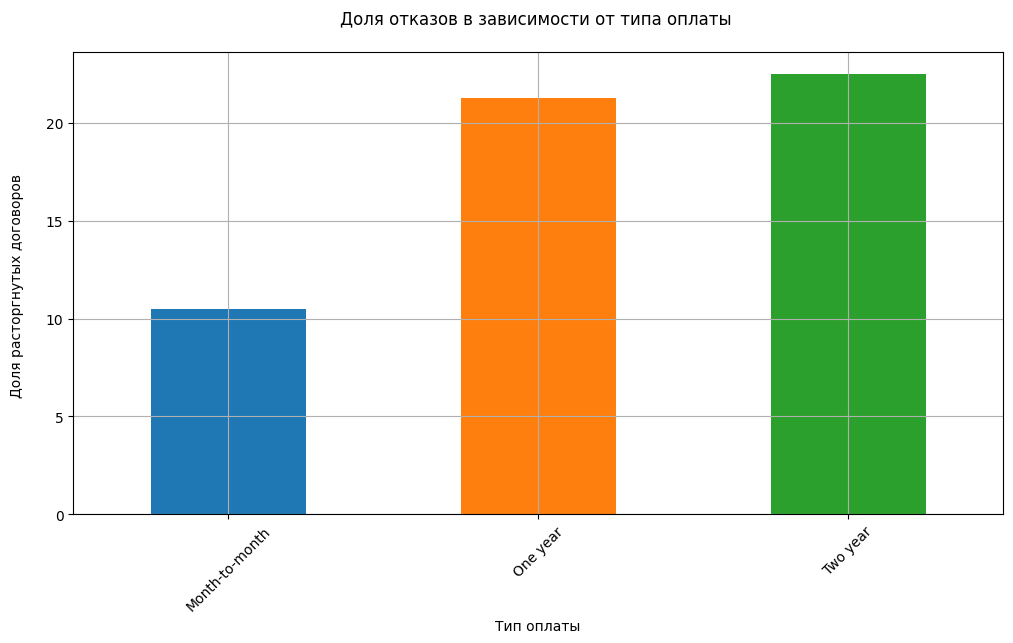

In [69]:
plt.figure(figsize=(12, 6))
(contract_df.groupby('type')['terminated'].mean() * 100).plot.bar(color=['C0', 'C1', 'C2'])
plt.title('Доля отказов в зависимости от типа оплаты \n')
plt.xlabel('Тип оплаты')
plt.ylabel('Доля расторгнутых договоров \n')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

У клиентов с ежемесячной оплатй видна относительно низкая доля отказов (около 10%). Значительно выше доля отказов у клиентов с ежегодным платежом. Самая высокая доля отказов среди тех, кто платит раз в 2 года. 

#### Электронный расчетный лист 

paperless_billing
1    4171
0    2872
Name: count, dtype: int64


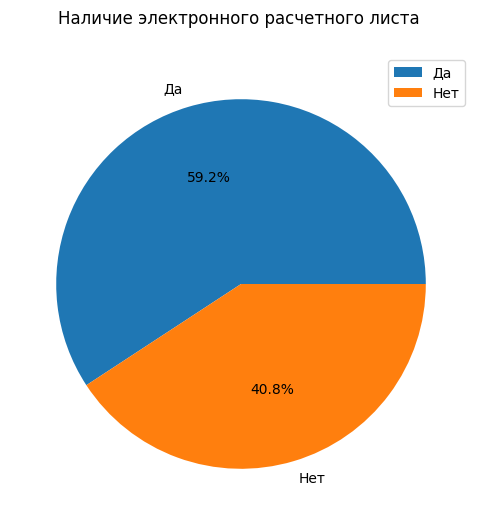

In [70]:
paperless_billing_counts = contract_df['paperless_billing'].value_counts()

print(paperless_billing_counts)

plt.figure(figsize=(6, 6))
plt.pie(paperless_billing_counts, labels=['Да', 'Нет'], autopct='%1.1f%%')
plt.title('Наличие электронного расчетного листа \n')
plt.legend(loc='upper right')
plt.show()

Большинство клиентов, почти 60%, предпочитают получение своих счетов в электронном виде.

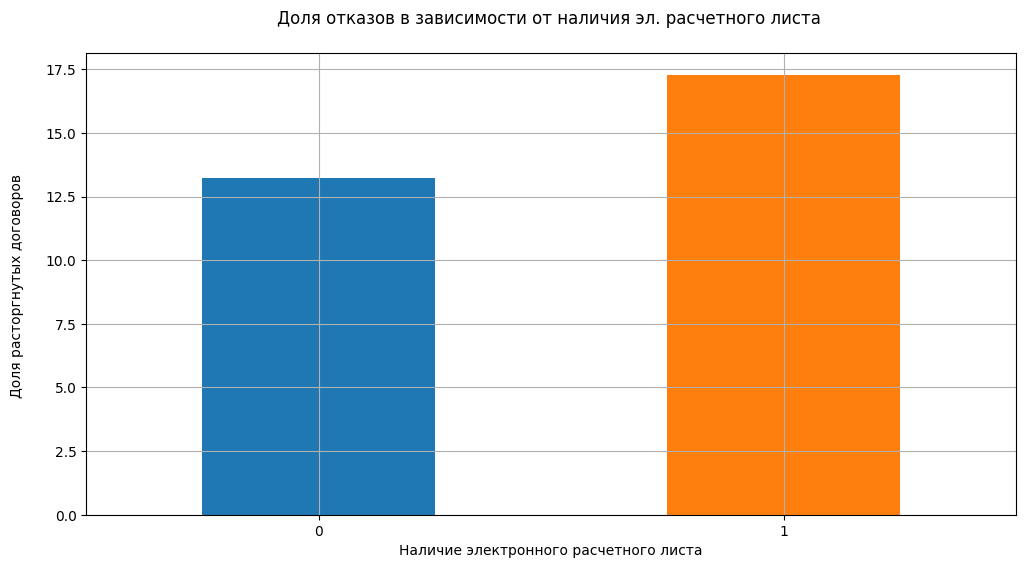

In [71]:
plt.figure(figsize=(12, 6))
(contract_df.groupby('paperless_billing')['terminated'].mean() * 100).plot.bar(color=['C0', 'C1', 'C2'])
plt.title('Доля отказов в зависимости от наличия эл. расчетного листа \n')
plt.xlabel('Наличие электронного расчетного листа')
plt.ylabel('Доля расторгнутых договоров \n')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

Доля отказов среди клиентов, не использующих электронный расчётный лист, ниже, чем среди тех, кто его использует.

#### Расходы за месяц

Проанализируем ежемесячные расходы ушедших и оставшихся клиентов. 

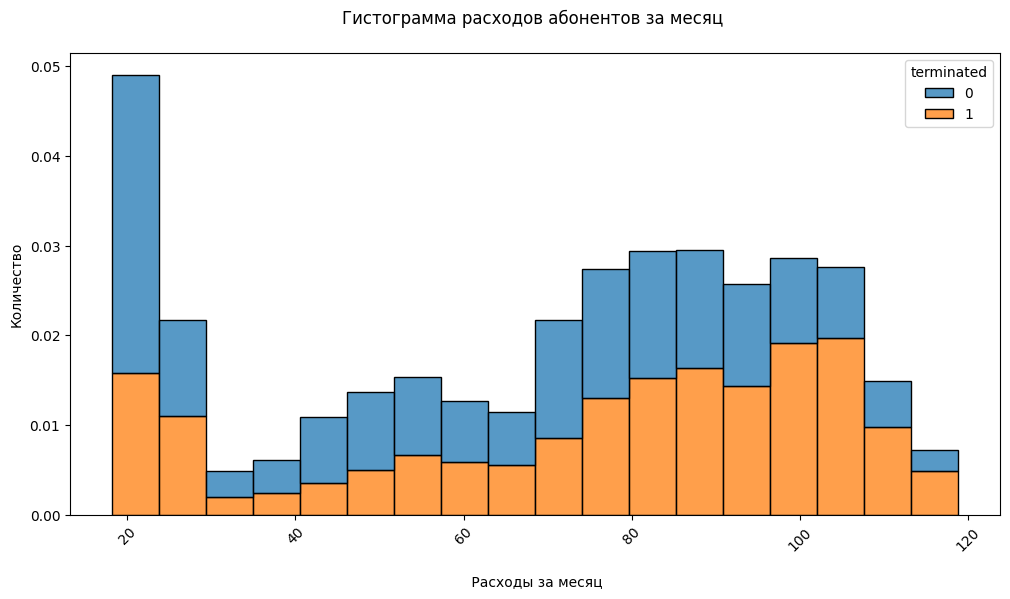

In [72]:
plt.figure(figsize=(12, 6))
sns.histplot(data=contract_df, x='monthly_charges', hue='terminated', multiple='stack', stat='density', common_norm=False)
plt.title('Гистограмма расходов абонентов за месяц \n')
plt.xlabel('\n Расходы за месяц')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Пик в левой части у обеих групп находится в диапазоне менее 20 у.е., что указывает на то, что большинство абонентов тратят относительно небольшую сумму в месяц.   
В целом можно отметить, что распределения в обеих группах практически идентичны.   
Можно сказать, что существует тенденция к увеличению оттока с увеличением месячных расходов.

In [73]:
contract_df.groupby('terminated')['monthly_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
terminated,,,,,,,,
0,5942.0,62.763455,29.844462,18.25,30.0625,69.2,87.2375,118.60
1,1101.0,75.546004,29.116213,18.40,56.1500,84.2,99.5000,118.75


Изучим диаграмму размаха расходов за месяц в разрезе факта ухода клиента. 

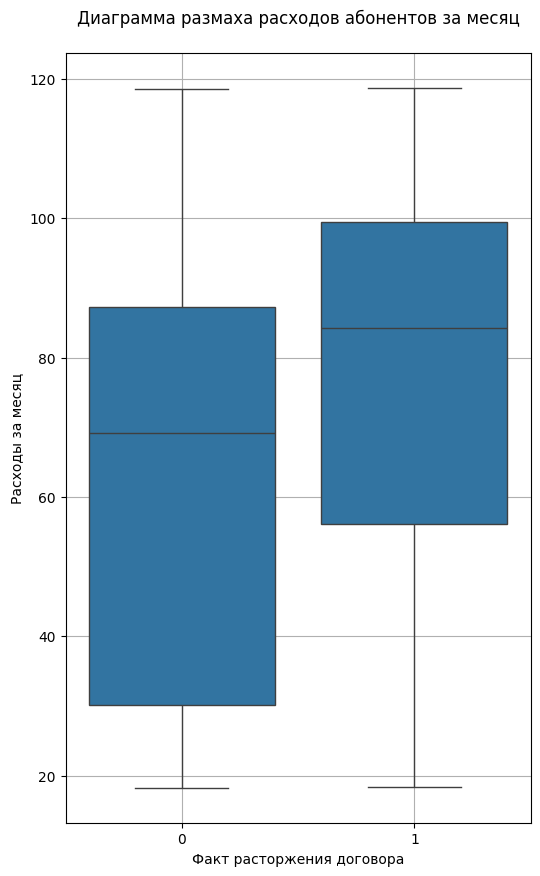

In [74]:
plt.figure(figsize=(6, 10))
sns.boxplot(x='terminated', y='monthly_charges', data=contract_df)
plt.title('Диаграмма размаха расходов абонентов за месяц\n')
plt.ylabel('Расходы за месяц')
plt.xlabel('Факт расторжения договора')
plt.grid(True)
plt.show()

In [75]:
terminated = contract_df[contract_df['terminated'] == 1]['monthly_charges']
not_terminated = contract_df[contract_df['terminated'] == 0]['monthly_charges']

In [76]:
results = ttest_ind(terminated, not_terminated, equal_var=False, alternative='greater', random_state=RANDOM_STATE)

alpha = 0.05 

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Средние месячных расходов для оставшихся и ушедших клиентов не равны.')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

9.330191988925199e-39
Отвергаем нулевую гипотезу. Средние месячных расходов для оставшихся и ушедших клиентов не равны.


Полученное p-значение очень мало и значительно меньше уровня значимости. Это означает, что есть статистически значимые доказательства для отвержения нулевой гипотезы, и мы можем утверждать, что существует значимая разница в средних месячных расходах между клиентами, которые ушли, и теми, кто остался. С учётом альтернативной гипотезы, результаты теста также указывают на то, что средние расходы ушедших клиентов больше, чем у оставшихся.

#### Общие расходы

Изучим, как распределены общие расходы в двух группах клиентов. 

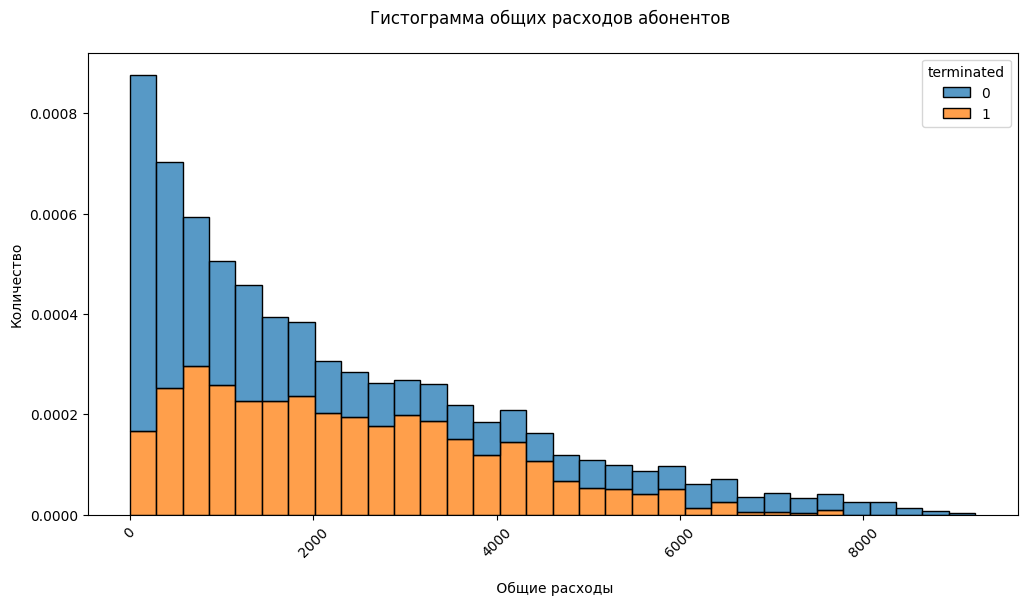

In [77]:
plt.figure(figsize=(12, 6))
sns.histplot(data=contract_df, x='total_charges', hue='terminated', multiple='stack', stat='density', common_norm=False)
plt.title('Гистограмма общих расходов абонентов \n')
plt.xlabel('\n Общие расходы')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

На гистограмме видно, наибольшее количество абонентов для обеих групп находится в самом низком диапазоне расходов.   Распределение группы абонентов, которые продолжают пользоваться услугами, имеет очень высокий пик в самом левом конце гистограммы, то есть они имеют наименьшее значение общих расходов.  
Распределение ушедших пользователей в целом более гладкое и не имеет таких ярких пиков.  
Однако в обеих группах гистограммы отображают тот факт, что меньшее число пользователей имеет очень высокие общие расходы. 

In [78]:
contract_df.groupby('terminated')['total_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
terminated,,,,,,,,
0,5942.0,2067.866420,2193.898483,0.00,374.3525,1192.80,3173.8375,9221.38
1,1101.0,2371.377275,1581.862275,77.84,1048.0500,2139.03,3404.9100,7649.76


Анализируя статистики, можно заметить, что 25-й, 50-й и 75-й перцентили расходов выше для клиентов, которые расторгли договор, что может указывать на более высокие расходы среди этой группы. 

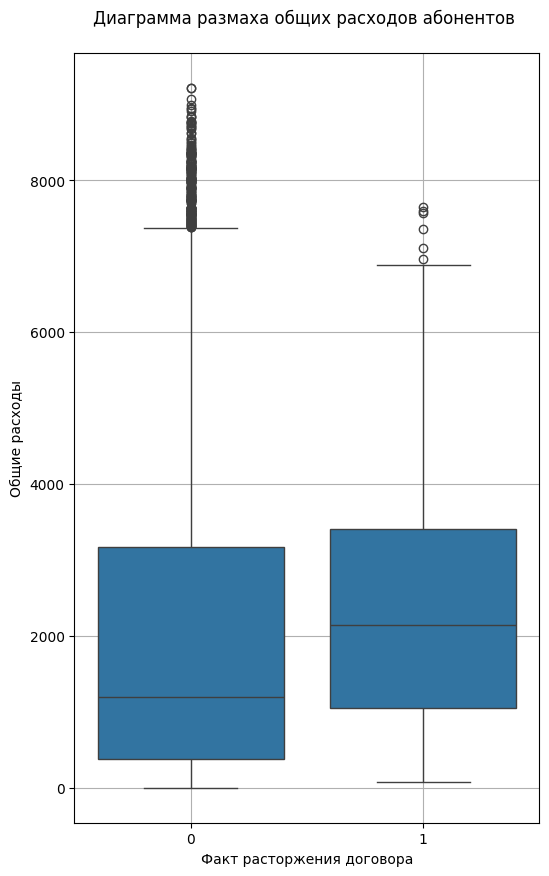

In [79]:
plt.figure(figsize=(6, 10))
sns.boxplot(x='terminated', y='total_charges', data=contract_df)
plt.title('Диаграмма размаха общих расходов абонентов \n')
plt.ylabel('Общие расходы')
plt.xlabel('Факт расторжения договора')
plt.grid(True)
plt.show()

На диаграмме размаха видно, что медиана общих расходов ушедших клиентов находится выше. Также видна значительная разница в первом квартиле, у ушедших клиентов он во много превосходит значение оставшихся. 

Также проведем t-test для сравнения средних общих расходов среди двух групп абонентов. 

In [80]:
terminated = contract_df[contract_df['terminated'] == 1]['total_charges']
not_terminated = contract_df[contract_df['terminated'] == 0]['total_charges']

In [81]:
results = ttest_ind(terminated, not_terminated, equal_var=False, alternative='greater', random_state=RANDOM_STATE)

alpha = 0.05 

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Средние общих расходов для оставшихся и ушедших клиентов не равны.')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

2.5865526759023983e-08
Отвергаем нулевую гипотезу. Средние общих расходов для оставшихся и ушедших клиентов не равны.


Как и в случае с ежемесячными расходами, мы получили очень маленькое p-значение. Это означает, что есть статистически значимые доказательства для отвержения нулевой гипотезы, и мы можем утверждать, что существует значимая разница в средних общих расходах между клиентами, которые ушли, и теми, кто остался. С учётом альтернативной гипотезы, результаты теста также указывают на то, что средние общие расходы ушедших клиентов больше, чем у оставшихся.

### Персональные данные клиентов

Изучим персональные данные клиентов. 

Для начала посмотрим на распределение по полу.

gender
Male      3555
Female    3488
Name: count, dtype: int64


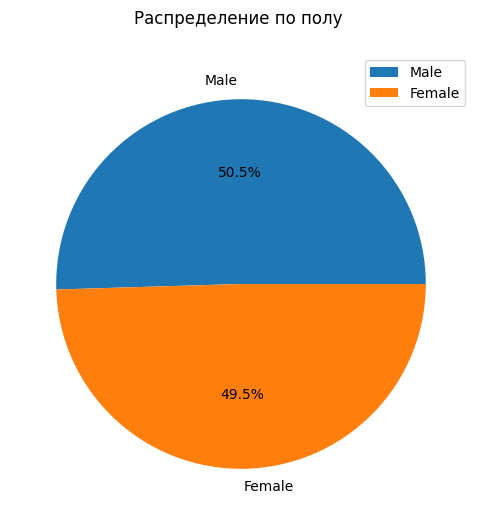

In [82]:
gender_counts = persons_df['gender'].value_counts()

print(gender_counts)

plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Распределение по полу \n')
plt.legend(loc='upper right')
plt.show()

Мужчин и женщин в выборке примерно равное количество. 

Теперь изучим, сколько в данных клиентов пенсионеров. 

senior_citizen
0    5901
1    1142
Name: count, dtype: int64


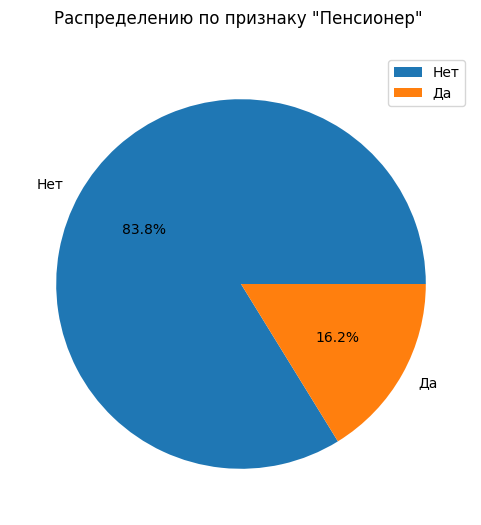

In [83]:
senior_counts = persons_df['senior_citizen'].value_counts()

print(senior_counts)

plt.figure(figsize=(6, 6))
plt.pie(senior_counts, labels=['Нет', 'Да'], autopct='%1.1f%%')
plt.title('Распределению по признаку "Пенсионер" \n')
plt.legend(loc='upper right')
plt.show()

Большая часть, почти 84%, не являются пенсионерами. 

Посмотрим, какая доля абонентов состоит в браке.

partner
0    3641
1    3402
Name: count, dtype: int64


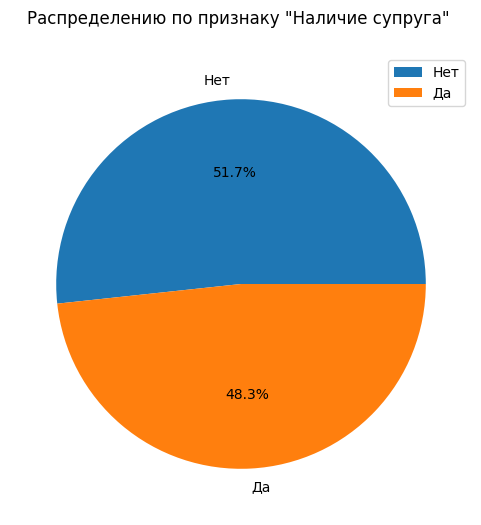

In [84]:
partner_counts = persons_df['partner'].value_counts()

print(partner_counts)

plt.figure(figsize=(6, 6))
plt.pie(partner_counts, labels=['Нет', 'Да'], autopct='%1.1f%%')
plt.title('Распределению по признаку "Наличие супруга" \n')
plt.legend(loc='upper right')
plt.show()

Состоящих в браке и холостых примерно равное количество.

Теперь посмотрим, какая доля абонентов имеет детей.

dependents
0    4933
1    2110
Name: count, dtype: int64


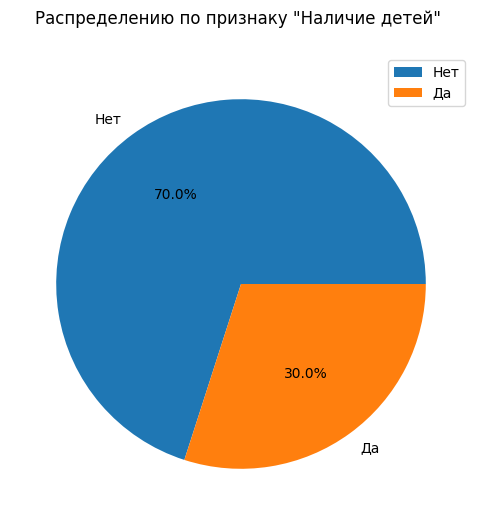

In [85]:
dependents_counts = persons_df['dependents'].value_counts()

print(dependents_counts)

plt.figure(figsize=(6, 6))
plt.pie(dependents_counts, labels=['Нет', 'Да'], autopct='%1.1f%%')
plt.title('Распределению по признаку "Наличие детей" \n')
plt.legend(loc='upper right')
plt.show()

70% клиентов не имеет детей, и только 30% имеют хотя бы одного ребенка.

### Интернет-услуги

Изучим данные об интернет услугах, которыми пользуются абоненты.

In [86]:
internet_df.head()

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customer_id,,,,,,,
7590-VHVEG,DSL,0,1,0,0,0,0
5575-GNVDE,DSL,1,0,1,0,0,0
3668-QPYBK,DSL,1,1,0,0,0,0
7795-CFOCW,DSL,1,0,1,1,0,0
9237-HQITU,Fiber optic,0,0,0,0,0,0


In [87]:
internet_dict = {
    'internet_service' : 'Тип подключения',
    'online_security' : 'Блокировка опасных сайтов',
    'online_backup' : 'Облачное хранилище файлов',
    'device_protection' : 'Антивирус',
    'tech_support' : 'Выделенная линия технической поддержки',
    'streaming_tv' : 'Стриминговое телевидение',
    'streaming_movies' : 'Каталог фильмов',
     1 : 'Подлючено',
     0 : 'Не подключено'
}

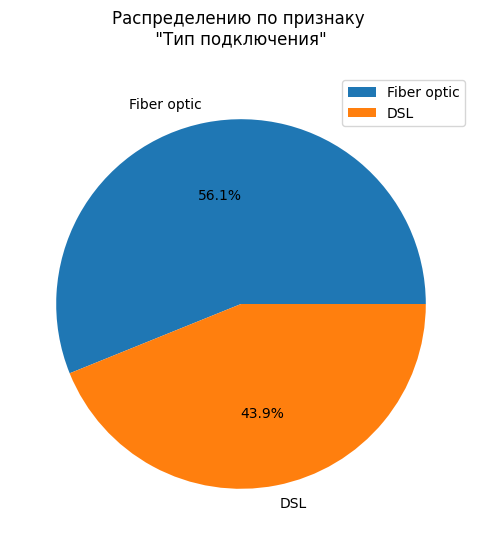

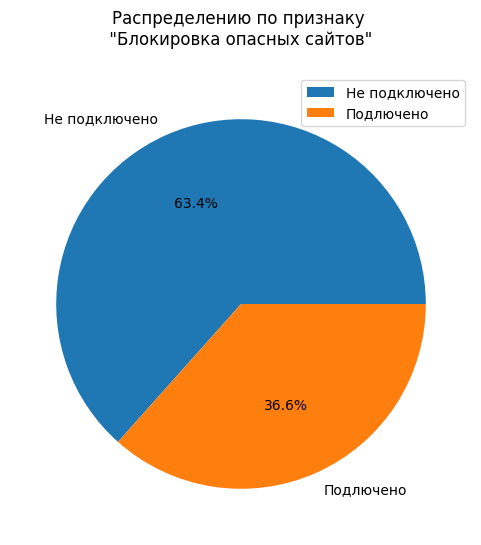

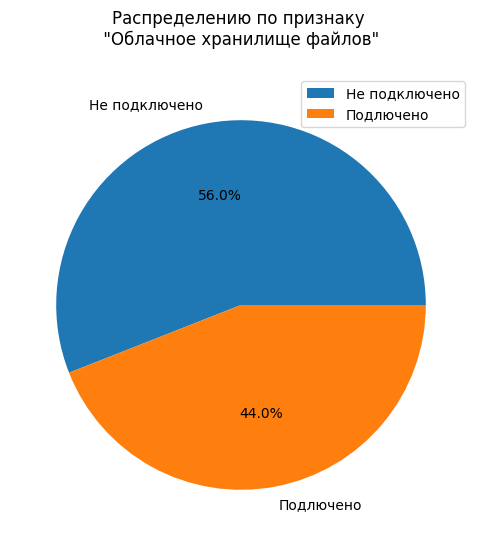

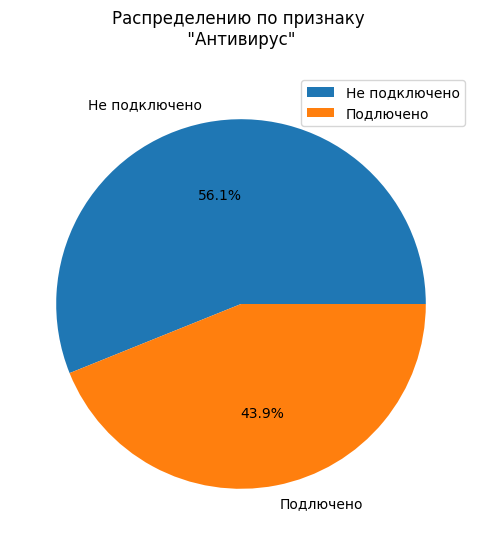

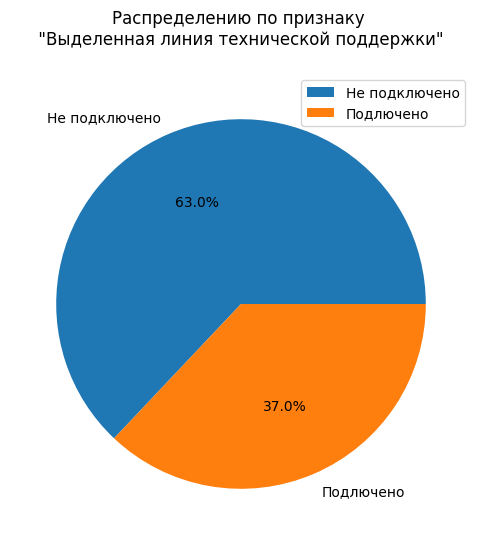

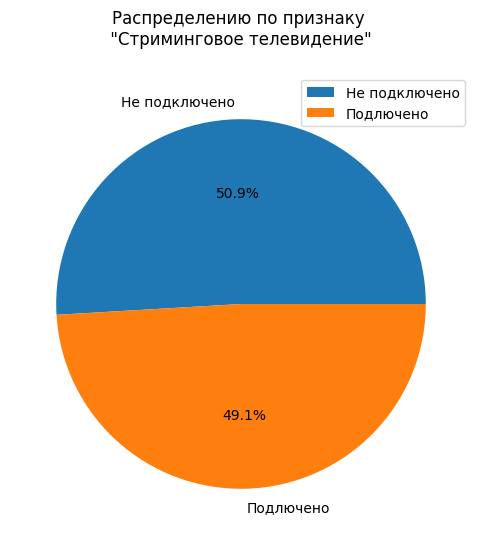

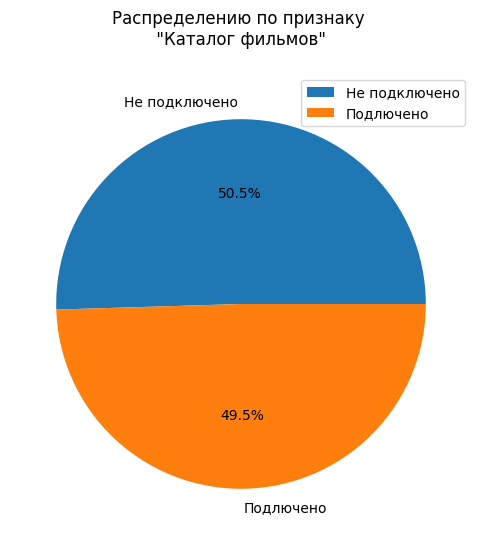

In [88]:
for col in internet_df.columns:
    
    val_counts = internet_df[col].value_counts()
    
    mapped_labels = val_counts.index.map(lambda x: internet_dict.get(x, x))

    plt.figure(figsize=(6, 6))
    plt.pie(val_counts, labels=mapped_labels, autopct='%1.1f%%')
    plt.title(f'Распределению по признаку \n "{internet_dict[col]}" \n')
    plt.legend(loc='upper right')
    plt.show()

- Тип подключения:
    - Большинство пользователей (56.1%) используют подключение через оптоволокно (Fiber optic). Оставшаяся часть пользователей (43.9%) использует DSL подключение.  

- Блокировка опасных сайтов: 
    - Большая часть пользователей (63.4%) не использует сервис блокировки опасных сайтов. Примерно треть пользователей (36.6%) подключила эту услугу.  
- Облачное хранение файлов:
    - Примерно 56% пользователей не используют облачное хранение файлов. Оставшиеся 44% пользователей используют сервис.
- Антивирус:
    - 56.1% пользователей не подключили антивирусную защиту. 43.9% пользователей используют антивирусную защиту.
- Выделенная линия технической поддержки:
    - Большинство пользователей (63.0%) не используют выделенную линию технической поддержки. Около трети пользователей (37.0%) подключили эту услугу.
- Стримингое телевидение:
    - Те, у кого подлкючена и не подключена услуга, находятся в соотношении примерно 50/50.
- Каталог фильмов:
    - Как и пользователи стримингово сервиса, пользователи с подключенным и не подключенном каталогом составляют примерно равную долю. 

### Услуги телефонии

Изучим данные по услугам телефонии. 

multiple_lines
0    3390
1    2971
Name: count, dtype: int64


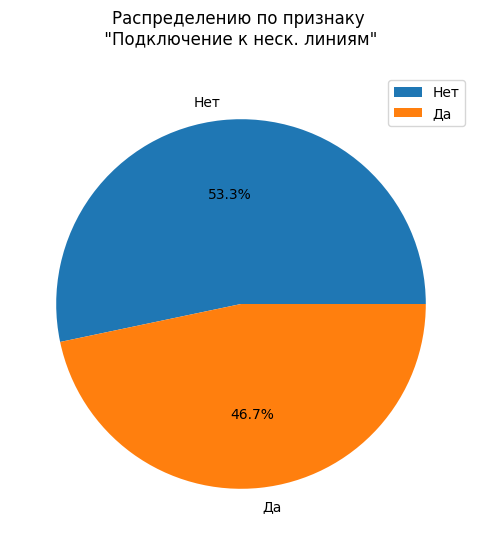

In [89]:
mult_lines_counts = phone_df['multiple_lines'].value_counts()

print(mult_lines_counts)

plt.figure(figsize=(6, 6))
plt.pie(mult_lines_counts, labels=['Нет', 'Да'], autopct='%1.1f%%')
plt.title('Распределению по признаку \n "Подключение к неск. линиям" \n')
plt.legend(loc='upper right')
plt.show()

Признак "подключение телефона к нескольким линиям одновременно" примерно равно распределен среди клиентов. 

## Объединение данных

Объединим все файлы в единый датафрейм. Будем использовать внешнее соединение, чтобы в итоговом датафрейме иметь данные про всех клиентов, в том числе про тех, кто использует только интернет или только телефонию.

In [90]:
df = contract_df.join([persons_df, internet_df, phone_df], how='outer')

In [91]:
df.isna().sum()

begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
duration                0
terminated              0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

В объединенном датафрейме мы получили большое количество пропусков, так как не все клиенты пользуются и услугами интернета у опреатора, и услугами телефонии. Заполним пропуски, чтобы явно разделять этих клиентов. 

In [92]:
def sum_services_or_fillna(row):
    if pd.notna(row['internet_service']):
        return str(int(row[services].sum()))
    else:
        return 'N/A'

Посчитаем общее количество сервисов, используемых абонентом, и удалим столбцы, показывающие использование каждого конкретного сервиса. 

In [93]:
df['number_of_services'] = df.apply(lambda x: sum_services_or_fillna(x), axis=1)

In [94]:
df = df.drop(columns=services)

In [95]:
df['internet_service'].fillna('N/A', inplace=True)

In [96]:
df['multiple_lines'].fillna('N/A', inplace=True)

In [97]:
df.isna().sum()

begin_date               0
end_date              5942
type                     0
paperless_billing        0
payment_method           0
monthly_charges          0
total_charges            0
duration                 0
terminated               0
gender                   0
senior_citizen           0
partner                  0
dependents               0
internet_service         0
multiple_lines           0
number_of_services       0
dtype: int64

In [98]:
df.sample(5)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,terminated,gender,senior_citizen,partner,dependents,internet_service,multiple_lines,number_of_services
customer_id,,,,,,,,,,,,,,,,
1875-QIVME,2019-11-01,NaT,Month-to-month,1,Electronic check,104.40,338.26,93,0,Female,0,1,0,Fiber optic,1,4
6048-QBXKL,2019-12-01,NaT,Month-to-month,1,Credit card (automatic),56.55,113.10,63,0,Female,1,0,0,DSL,1,1
9540-JYROE,2019-05-01,NaT,Month-to-month,1,Mailed check,70.10,649.83,277,0,Male,0,0,0,Fiber optic,0,0
2947-DOMLJ,2019-10-01,NaT,Month-to-month,0,Mailed check,50.60,202.40,124,0,Male,0,0,1,DSL,0,1
9537-JALFH,2014-05-01,NaT,Two year,0,Bank transfer (automatic),19.90,1373.10,2103,0,Male,0,1,1,N/A,0,N/A


Все пропуски были заполнены и датафрейм готов для дальнейшего анализа, уже объединенных данных. 

## Анализ объединенного датафрейма

In [99]:
columns_dict = {
    'gender' : 'Пол',
    'senior_citizen' : 'Пенсионер', 
    'partner' : 'Наличие супруга', 
    'dependents' : "Наличие детей",
    'internet_service' : "Тип подключения интернета", 
    'multiple_lines' : "Подключение телефона к нескольким линиям одновременно", 
    'number_of_services' : "Количество услуг"
}

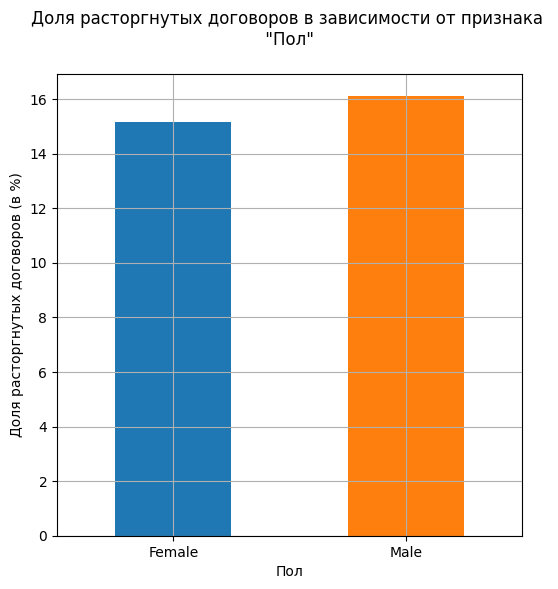

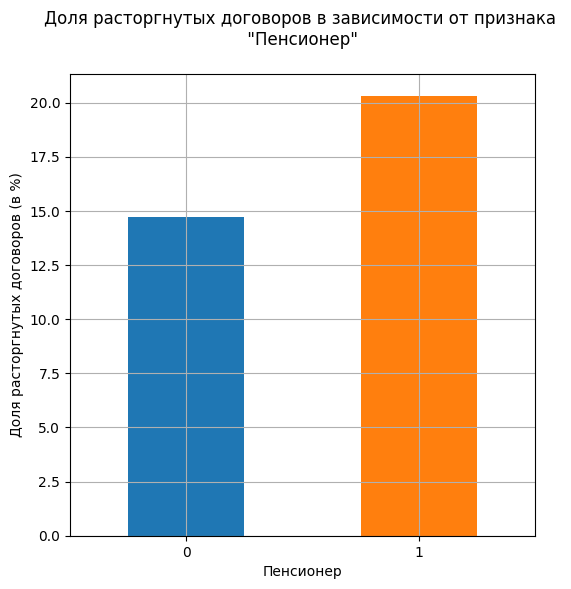

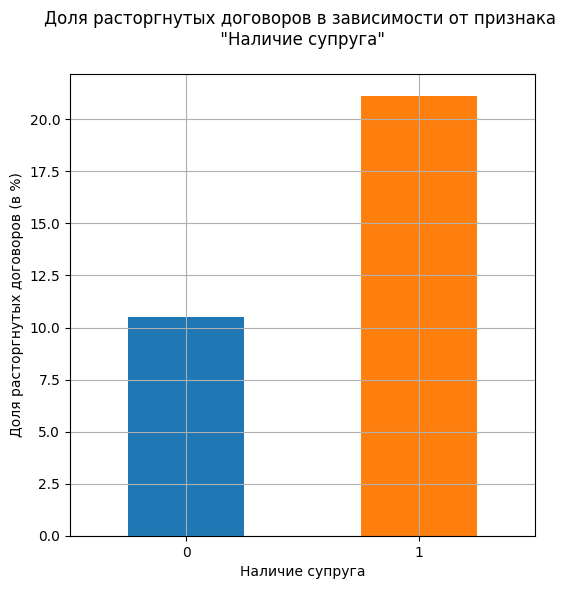

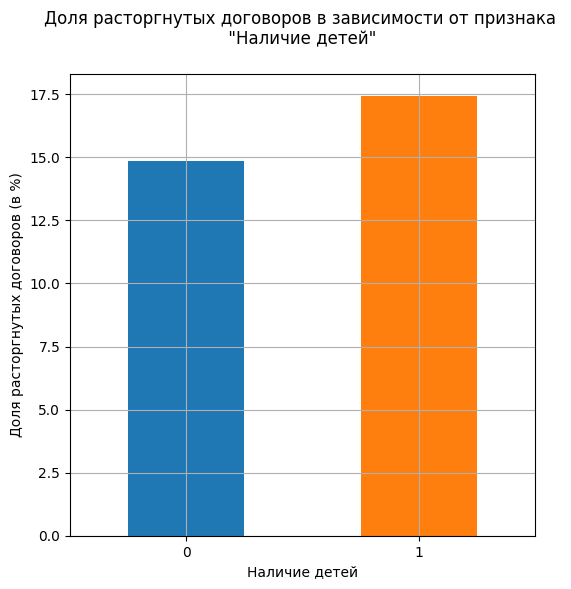

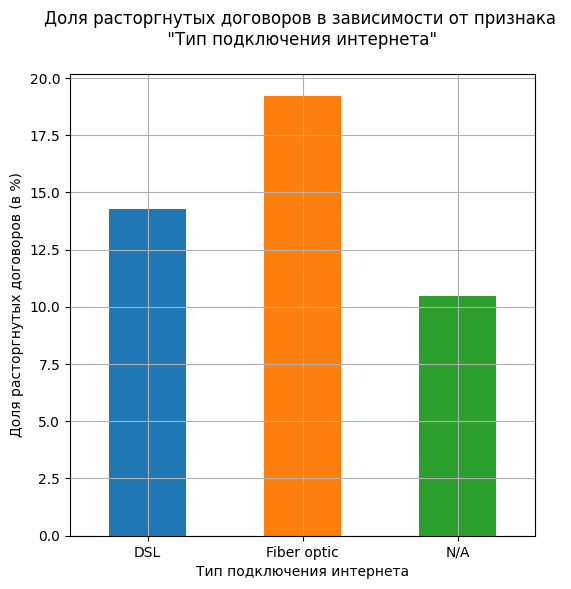

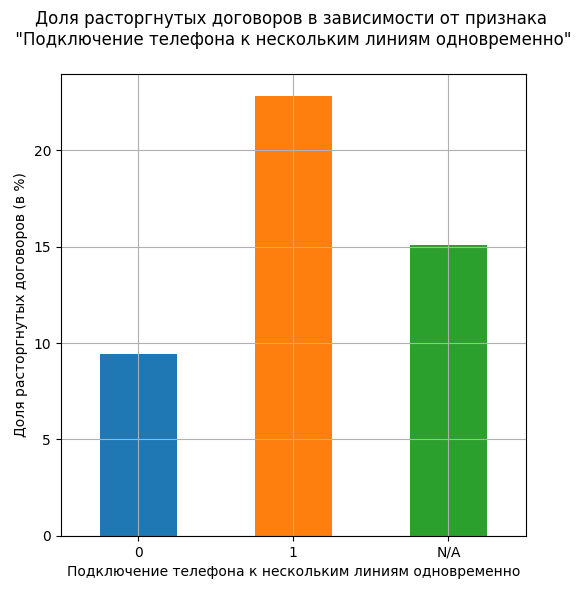

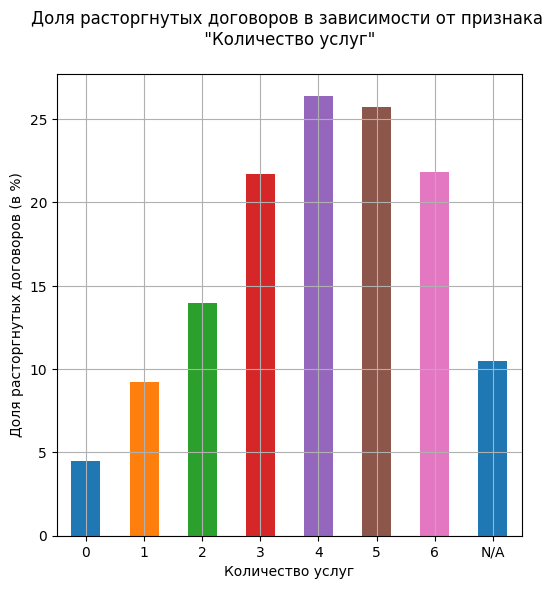

In [100]:
for col in ['gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'multiple_lines', 'number_of_services']:
    plt.figure(figsize=(6, 6))
    (df.groupby(col)['terminated'].mean() * 100).plot.bar(color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'])
    plt.title(f'Доля расторгнутых договоров в зависимости от признака \n "{columns_dict[col]}" \n')
    plt.xticks(rotation=0)
    plt.xlabel(columns_dict[col])
    plt.ylabel('Доля расторгнутых договоров (в %)')
    plt.grid(True)
    plt.show()

Из диаграмм можно сделать следующие выводы: 
- Мужчины и женщины почти одинаково часто расторгают договоры
- Пенсионеры расторгают договоры на 5% чаще (всего 20%), чем не пенсинеры
- Абоненты, состоящие в браке, расторгают договор в 2 раза чаще, чем холостые
- Доля расторгнутых договоров среди пользователей с детьми - примерно 17.5%, среди бездетных - 15%
- Наибольшая доля уходов среди пользователей с подключенным оптоволокном (почти 20%), затем идут пользователи с телефонной линией (чуть меньше 15%) и меньше всего (около 10%) у пользователей, не использующие услугу подключения интернета
- Почти 25% пользователей с подключенными несколькими телефонными линиями расторгли договор, и только 15% среди тех, кто этой услугой не пользуется
- Более 25% клиентов с подключенными 4 или 5 услугами перестали пользоваться услугами компании, также более 20% ушло среди тех, кто подключил 3 и 6 услуг. Менее 5% ушли среди тех, кто не подключал никаких услуг. 

Проведем корреляционный анализ. Используем библиотеку phik, она позволяет вычислять взаимосвязи между различными типами признаков (категориальными, непрерывными и их комбинациями). Явно укжем столбцы с некпрерывными значениями. 

In [101]:
corr = df.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration'])
corr

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,terminated,gender,senior_citizen,partner,dependents,internet_service,multiple_lines,number_of_services
begin_date,1.000000,0.000000,0.766249,0.081447,0.456389,0.421886,0.774207,0.978526,0.450254,0.011268,0.050862,0.473514,0.208564,0.192197,0.468035,0.594173
end_date,0.000000,1.000000,0.398284,0.065379,0.120097,0.000000,0.092550,0.591422,NaN,0.046046,0.054282,0.086772,0.076916,0.000000,0.142053,0.205353
type,0.766249,0.398284,1.000000,0.106860,0.277462,0.388444,0.470860,0.634213,0.094015,0.000000,0.086231,0.179736,0.147680,0.505187,0.244410,0.573091
paperless_billing,0.081447,0.065379,0.106860,1.000000,0.370495,0.467812,0.201703,0.026662,0.083398,0.000000,0.242133,0.013218,0.172593,0.231438,0.099953,0.426404
payment_method,0.456389,0.120097,0.277462,0.370495,1.000000,0.399526,0.335666,0.350934,0.214832,0.000000,0.292725,0.243008,0.224903,0.323886,0.174849,0.529255
monthly_charges,0.421886,0.000000,0.388444,0.467812,0.399526,1.000000,0.710905,0.387556,0.226280,0.008175,0.304985,0.203545,0.184366,0.919002,0.709983,0.808246
total_charges,0.774207,0.092550,0.470860,0.201703,0.335666,0.710905,1.000000,0.848267,0.302890,0.000000,0.135650,0.381958,0.084247,0.490081,0.467787,0.577513
duration,0.978526,0.591422,0.634213,0.026662,0.350934,0.387556,0.848267,1.000000,0.374598,0.000000,0.064206,0.453655,0.198729,0.060094,0.347233,0.446694
terminated,0.450254,NaN,0.094015,0.083398,0.214832,0.226280,0.302890,0.374598,1.000000,0.008581,0.086159,0.226688,0.046871,0.056621,0.105101,0.266057
gender,0.011268,0.046046,0.000000,0.000000,0.000000,0.008175,0.000000,0.000000,0.008581,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Для поиска мультиколлинеарности в данных установим порог корреляции равным 0.8 и проанализируем полученную матрицу корреляции.

In [102]:
threshold = 0.8
high_corr_pairs = []

for i in corr.columns:
    for j in corr.columns:
        if i!=j and abs(corr.loc[i, j]) > threshold:
            high_corr_pairs.append((i, j, corr.loc[i, j]))
            
pd.DataFrame(high_corr_pairs, columns=['feature 1', 'feature 2', 'correlation']).sort_values(by='correlation', ascending=False)

,feature 1,feature 2,correlation
0,begin_date,duration,0.978526
4,duration,begin_date,0.978526
1,monthly_charges,internet_service,0.919002
6,internet_service,monthly_charges,0.919002
3,total_charges,duration,0.848267
5,duration,total_charges,0.848267
2,monthly_charges,number_of_services,0.808246
7,number_of_services,monthly_charges,0.808246


Высокое значение корреляции имеет между собой ряд признаков.  
Однако часть из них нельзя назвать взаимозаменяемыми. Так, например, несмотря на высокое значение корреляции между ежемесячными расходами и количеством интернет-сервисов и типом подлючения, удаление одного из этих признаков может привести к потере ценной для обучения моделей информации. 
Признак начала даты договора же действительно можно и нужно будет удалить, так как мы посчитали общую длительность договора в днях. 


## Подготовка данных для обучения моделей

На данном этапе подготовим данные к обучению моделей. Удалим признаки даты начала и окончания договора. Мы знаем для каждого клиента продолжительность действия его договора, а также факт его ухода. 

In [103]:
def remove_features(data):
    
    final_data = data.copy()
    
    final_data = final_data.drop(columns=['begin_date', 'end_date'])
    
    return final_data

In [104]:
final_df = remove_features(df)

Определим признаки и целевой признак. 

In [105]:
features = final_df.drop(['terminated'], axis=1)
target = final_df['terminated']

Разделим данные на обучающую тестовую выборки в соотношении 3/1. 

In [106]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=RANDOM_STATE)

In [107]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 0916-QOFDP to 9057-SIHCH
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                5282 non-null   object 
 1   paperless_billing   5282 non-null   object 
 2   payment_method      5282 non-null   object 
 3   monthly_charges     5282 non-null   float64
 4   total_charges       5282 non-null   float64
 5   duration            5282 non-null   int64  
 6   gender              5282 non-null   object 
 7   senior_citizen      5282 non-null   object 
 8   partner             5282 non-null   object 
 9   dependents          5282 non-null   object 
 10  internet_service    5282 non-null   object 
 11  multiple_lines      5282 non-null   object 
 12  number_of_services  5282 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 577.7+ KB


Так как в данных присутствуют числовые и категориальные переменные, проведем их предобработку. Масштабируем числовые признаки и используем OHE-кодирование для категориальных. 

In [108]:
numerical_columns = ['duration', 'monthly_charges', 'total_charges']

categorical_columns = [col for col in features_train.columns if col not in numerical_columns]

In [109]:
scaler = StandardScaler()
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

In [110]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_columns),
        ('cat', ohe, categorical_columns)
    ])

## Обучение моделей 

Обучим три типа моделей : Логистическую регрессию, Случайный лес и CatBoost (градиентный бустинг на деревьях решений). 

Для обучения и поиска лучших гиперпараметров будем использовать кросс-валидацию. Метрика оценки - ROC-AUC. 

### Логистическая регрессия

In [111]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

param_grid = {
    'lr__solver' : ['lbfgs', 'liblinear'],
    'lr__C': [0.001, 0.01, 0.1, 1, 10]
}

lr_grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')

lr_grid_search.fit(features_train, target_train)

print(f"Параметры лучшей модели логистической регрессии : {lr_grid_search.best_params_}")
print(f"ROC-AUC для лучшей модели логистической регрессии : {lr_grid_search.best_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Параметры лучшей модели логистической регрессии : {'lr__C': 10, 'lr__solver': 'lbfgs'}
ROC-AUC для лучшей модели логистической регрессии : 0.7581984110649108


Логистическая регрессия показала значение ROC-AUC, равное 0.76. 

### Случайный лес

In [112]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

param_grid = {
    'rf__n_estimators': [10, 50, 100, 200],
    'rf__max_depth': [5, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}
    
rf_grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')

rf_grid_search.fit(features_train, target_train)

print(f"Параметры лучшей модели случайного леса: {rf_grid_search.best_params_}")
print(f"ROC-AUC для лучшей модели случайного леса: {rf_grid_search.best_score_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Параметры лучшей модели случайного леса: {'rf__max_depth': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
ROC-AUC для лучшей модели случайного леса: 0.8219917606224244


Показатель ROC-AUC у случайного леса выше и составляет 0.82. 

### CatBoost

In [113]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('cb', CatBoostClassifier(random_state=RANDOM_STATE, verbose=0))
])

param_grid = {
    'cb__depth': list(range(4, 11)),
    'cb__learning_rate': [0.01, 0.05, 0.1, 1],
    'cb__iterations': [10, 50, 100]
}

cb_grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0, scoring='roc_auc')

cb_grid_search.fit(features_train, target_train)

print(f"Параметры лучшей модели CatBoost: {cb_grid_search.best_params_}")
print(f"ROC-AUC для лучшей модели CatBoost: {cb_grid_search.best_score_}")

Параметры лучшей модели CatBoost: {'cb__depth': 4, 'cb__iterations': 100, 'cb__learning_rate': 1}
ROC-AUC для лучшей модели CatBoost: 0.9288489379769446


Модель CatBoost показала наилучший результат, ее значение ROC-AUC равно 0.93. 

### Вывод

Среди трех моделей достаточный и лучший показатель метрики ROC-AUC мы получили при использовании модели CatBoost, он равен 0.93.  

На втором месте Случайный лес (0.82).  

Худший результат показала модель Логистической регрессии (0.75). 

## Тестирование модели

Используем модель CatrBoost, показавшую лучшее значение метрики на кросс-валидации. Протестируем ее на тестовой выборке. 

In [114]:
best_model = cb_grid_search.best_estimator_

In [115]:
pred_proba = best_model.predict_proba(features_test)[:, 1]

In [116]:
roc_auc_score(target_test, pred_proba)

0.964540251995768

На тестовой выборке мы получили очень высокое значение ROC-AUC, равное 0.96.

Отобразим ROC-кривую. 

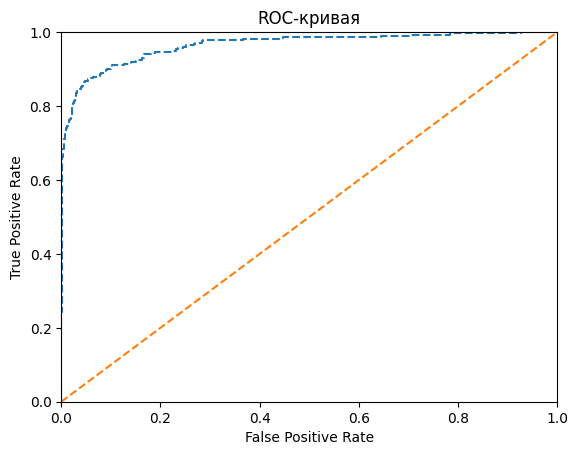

In [117]:
fpr, tpr, thresholds = roc_curve(target_test, pred_proba) 
plt.figure()
plt.plot(fpr, tpr, linestyle='--')

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0,1)
plt.ylim(0,1) 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

На графике видно, что ROC-кривая обученной модели проходит намного выше базовой линии. 

Также посмотрим на значение accuracy, которое выдаст наша обученная модель.

In [118]:
accuracy_score(target_test, best_model.predict(features_test))

0.9483248154457694

Значение accuracy также очень высоко и равно 0.95. 

### Сравнение результатов с dummy-моделью

Для более корректных выводов о результате работы нашей модели сравним ее с dummy-моделью.

In [119]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('dummy', dummy_clf)
])

pipeline.fit(features_train, target_train)

dummy_pred = pipeline.predict_proba(features_test)[:, 1]

In [120]:
roc_auc_score(target_test, dummy_pred)

0.5

Как и ожидалось, значение ROC-AUC у дамми-модели будет равно 0.5, что и указывает на случайные предсказания модели.  
Обученная модель намного превосходит базовую модель, предсказывающую самый частовстречаемый класс. 

### Анализ результатов

#### Важность признаков

Изучим, какие признаки модель посчитала наиболее важными для обучения и предсказания. 

In [121]:
catboost_model = best_model.named_steps['cb']
feature_importances = catboost_model.feature_importances_

In [122]:
ohe_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
all_feature_names = numerical_columns + list(ohe_feature_names)

In [123]:
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importances
})

importance_df = importance_df.sort_values(by='importance', ascending=False)

importance_df

,feature,importance
0,duration,66.883419
1,monthly_charges,7.925118
2,total_charges,7.504642
4,type_Two year,3.398422
11,partner_1,2.216222
3,type_One year,1.404435
8,payment_method_Mailed check,1.401183
5,paperless_billing_1,1.360250
12,dependents_1,1.145523
16,multiple_lines_N/A,1.067432


Из данного списка видно, что признак `duration` имеет наибольшую важность ,и можно сказать, что продолжительность действия договора очень сильно влияет на прогнозирование. Также важными признаками являются `monthly_charges` и `total_charges`.

Признаки `gender_Male`, `internet_service_N/A`, и `number_of_services_N/A` имеют нулевую важность, что означает, что они не оказывают влияния на модель и могут быть исключены из рассмотрения.

#### Матрица ошибок

Изучим матрицу ошибок. 

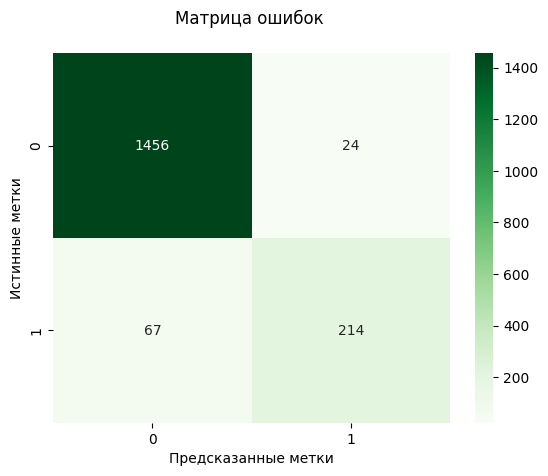

In [124]:
pred = best_model.predict(features_test)

conf_matrix = confusion_matrix(target_test, pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.title('Матрица ошибок \n')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

Из матрицы ошибок видно, что модель правильно предсказала 1456 случаев, когда клиент не ушел (True Negative) и 214 случаев, когда клиент ушел (True Positive). При этом в 67 случаях модель предсказала, что клиент останется, но он расторг договор (False Negative) и 24 случая, что клиент уйдет, но он остался (False Positive). 

## Вывод

В ходе работы над проектом были выполнены следующие шаги и получены следующие выводы: 
1. **Загрузка и знакомство с данными.**   

Было загружено и изучено 4 файла: 
- Договоры
    - Датафрейм содержит 7043 записи и 7 столбцов.
    - Обработка пропусков в столбце `total_charges`: замена пропусков на 0, так как клиенты с пропусками в данном поле только что оформили договоры.
    - Создание двух новых столбцов: "продолжительность действия договора клиента в днях" - `duration` и "факт ухода клиента" - `terminated` на основе информации о дате начала и дате окончания договора. Для клиентов, которые не расторгли договор, продолжительность рассчитана между датой актуальности данных и датой начала договора.
- Персональные данные клиентов
    - Датафрейм содержит 7043 записи и имеет 4 столбца.
- Интернет-услуги
    - Датафрейм содержит 5517 записей и имеет 7 столбцов.
- Услуги телефонии
    - Датафрейм содержит 6361 запись и имеет 1 столбец.

Во всех датафреймах индексом является уникальный идентификатор клиента. Также для всех датафреймов названия колонки были приведены к змеиному регистру, было произведено приведение к корректным типам данных.  


2. **Исследовательский анализ данных.**

На данном этапе был проведен исследовательский анализ данных из каждого датафрейма.
- Договоры
    - Дата начала действия договора   
    Проведен анализ временного ряда с количеством заключенных договоров. 
        - Исходные данные: Начальный пик, возможно, связанный с маркетинговой акцией, сменяется спадом и последующим ростом.
        - Тренд: В начале периода наблюдается спад, затем начинается устойчивый рост с 2018 года.
        - Сезонность: График показывает сезонные колебания, с яркими пиками и спадами в разные месяцы.
    Изучив сезонность более подробно, мы выявили следующие особенности:
    - Пик в начале года, особенно в феврале, может быть связан с сезонным увеличением числа заключенных договоров, возможно, из-за специальных предложений или маркетинговых акций.
    - Спад весной, после февральского пика, может указывать на периоды сниженного интереса к услугам или окончание акционного периода.
    - Летние колебания в графике показывают взлеты и падения.
    - Подъем к концу года, в октябре и ноябре, может быть связан с изменениями в поведении клиентов, возможно, вызванными сезонными маркетинговыми кампаниями.

        Анализ данных показал, что в начале работы компании был высокий уровень расторжений договоров, хотя количество заключенных договоров было небольшим. Однако с течением времени доля расторжений снижалась, что свидетельствует о стабилизации бизнес-процессов и улучшении условий договоров.

        В последующие годы наблюдалась волатильность в доле расторгнутых договоров, но общая тенденция указывает на их постепенное сокращение. К 2020 году доля расторгнутых договоров стала практически нулевой - клиенты, присоединившиеся к компании позднее, реже расторгают свои договоры, чем давние клиенты.  
    
    - Дата окончания действия договора  
    Проведен анализ временного ряда даты окончания действия договора и количества расторгнутых договоров. 
        - Исходные данные: График показывает общий тренд на увеличение количества расторгнутых договоров со временем. Однако следует отметить, что этот рост может быть обусловлен также увеличением общего числа клиентов в компании.
        - Тренд: Наблюдается стабильный рост количества расторгнутых договоров на протяжении всего анализируемого периода.
        - Сезонность: Расторжения договоров происходят чаще в марте, июле и сентябре и ноябре. 
    - Длительность договора
        - Для нерасторгнутых договоров наблюдается разнообразие продолжительности, от коротких до долгосрочных, в то время как у расторгнутых договоров продолжительность чаще находится в интервале 400-1300 дней.
        - Клиенты, расторгнувшие договоры, редко делают это в начальный период и редко после длительного использования услуг более 4.5 лет.
        - Проведенный статистический тест не обнаружил статистически значимых различий в средней продолжительности договоров у ушедших и оставшихся клиентов.
    - Расторгнутые договоры
       - Из проведенного анализа видно, что большинство клиентов (84.4%) продолжают пользоваться услугами оператора, в то время как 15.6% расторгли договор.
    - Тип оплаты
        - Большинство клиентов предпочитают оплату по месячной системе (55%), наименьшее число (20.9%) - ежегодную оплату.
        - У клиентов с ежемесячной оплатой видна относительно низкая доля отказов (около 10%). Значительно выше доля отказов у клиентов с ежегодным платежом. Самая высокая доля отказов среди тех, кто платит раз в 2 года.
    - Электронный расчетный лист
        - Большинство клиентов, почти 60%, предпочитают получение своих счетов в электронном виде.
        - Доля отказов среди клиентов, не использующих электронный расчётный лист, ниже, чем среди тех, кто его использует.
    - Расходы за месяц
        - Распределения расходов за месяц среди ушедших и оставшихся клиентов практически идентичны, но существует тенденция к увеличению оттока с увеличением месячных расходов.
        - Статистический анализ подтвердил наличие статистически значимой разницы в средних месячных расходах между клиентами, которые ушли, и теми, кто остался, причем средние расходы ушедших клиентов оказались выше.
    - Общие расходы
        - Наибольшее количество абонентов для обеих групп находится в самом низком диапазоне расходов.
        - Распределение группы абонентов, которые продолжают пользоваться услугами, имеет очень высокий пик в самом левом конце гистограммы, то есть они имеют наименьшее значение общих расходов. Распределение ушедших пользователей в целом более гладкое и не имеет таких ярких пиков.
        - В обеих группах гистограммы отображают тот факт, что меньшее число пользователей имеет очень высокие общие расходы.
        - t-test показал, что существует значимая разница в средних общих расходах между клиентами, которые ушли, и теми, кто остался, причем средние общие расходы ушедших клиентов оказались выше.
- Персональные данные
    - Пол клиентов
        - Распределение по полу клиентов примерно равномерное, с небольшим преимуществом мужчин.
    - Пенсионеры
        - Большая часть клиентов, около 84%, не являются пенсионерами.
    - Семейное положение
        - Доля клиентов, состоящих в браке, примерно равна доле холостых клиентов.
    - Наличие детей
        - Примерно 70% клиентов не имеют детей, в то время как остальные 30% имеют хотя бы одного ребенка.
- Интернет-услуги
    - Тип подключения к интернету
        - Большинство пользователей (56.1%) используют подключение через оптоволокно (Fiber optic), в то время как оставшаяся часть пользователей (43.9%) использует DSL подключение.
    - Блокировка опасных сайтов
        - Большая часть пользователей (63.4%) не использует сервис блокировки опасных сайтов, и только примерно треть пользователей (36.6%) подключила эту услугу.
    - Облачное хранение файлов
        - Примерно 56% пользователей не используют облачное хранение файлов, в то время как оставшиеся 44% пользователей используют эту услугу.
    - Антивирус
        - Большинство пользователей (56.1%) не подключили антивирусную защиту, и только 43.9% пользователей используют антивирусную защиту.
    - Выделенная линия технической поддержки
        - Большинство пользователей (63.0%) не используют выделенную линию технической поддержки, и только около трети пользователей (37.0%) подключили эту услугу.
    - Стриминговое телевидение
        - Доля пользователей с подключенным и не подключенным стриминговым телевидением примерно равна.
    - Каталог фильмов
        - Доля пользователей с подключенным и не подключенным каталогом фильмов также примерно равна.
- Услуги телефонии
    - Признак "подключение телефона к нескольким линиям одновременно" примерно равномерно распределен среди клиентов.
    
3. **Объединение данных**  
    - Данные были объединены в единый датафрейм с использованием внешнего соединения. Это позволило получить информацию о всех клиентах, включая тех, кто пользуется только интернетом или только телефонией.
    - Для дальнейшего анализа были заполнены появившиеся пропуски.
    - Было посчитано общее количество услуг, используемых каждым абонентом, и были удалены столбцы, отражающие использование каждой конкретной услуги.
      
      
4. **Анализ объединенного датафрейма**

    - Пол клиента не оказывает существенного влияния на решение о расторжении договора.
    - Пенсионеры реже расторгают договоры по сравнению с не пенсионерами.
    - Семейное положение может повлиять на решение о расторжении договора, при этом клиенты, состоящие в браке, склонны к расторжению договора чаще, чем холостые.
    - Наличие детей не имеет значительного влияния на решение о расторжении договора.
    - Подключение интернета через оптоволокно (Fiber optic) связано с более высокой долей расторжения договоров по сравнению с DSL подключением.
    - Подключение нескольких телефонных линий также связано с более высокой долей расторжения договоров.
    - Клиенты, подключающие больше услуг (более 3), более склонны к расторжению договоров.
    
    Также был проведен корреляционный анализ, который позволил выявить некоторые высокие корреляции между признаками. Однако, исходя из особенностей данных и предметной области, было решено оставить в данных признаки, имеющие высокое значение корреляции. Удалены будут только столбцы с датой начала и датой окончания договора.  
    
5. **Подготовка данных для обучения моделей**

    - Были удалены признаки даты начала и окончания договора, так как мы уже имеем информацию о продолжительности действия договора в виде отдельного признака.
    - Также были определены признаки и целевой признак. Признак `terminated` стал является целевым. 
    - Данные были разделены на обучающую и тестовую выборки в соотношении 3/1.
    - Был подготовлен преобразователь данных : для числовых признаков в ходе оубчения будет выполнено масштабирование, а для категориальных признаков - OHE-кодирование, чтобы они стали пригодными для обучения моделей машинного обучения  
    
    
6. **Обучение моделей**  

    В исследовании были обучены и оценены три типа моделей: Логистическая регрессия, Случайный лес и CatBoost (градиентный бустинг на деревьях решений) с использованием кросс-валидации и метрики ROC-AUC. 
    
    - Наилучшее значение ROC-AUC, равное 0.93, продемонстрировала модель CatBoost. 
    - Модель Случайного леса также показала хорошие результаты с показателем ROC-AUC в 0.82, занимая второе место. 
    - Логистическая регрессия показала наименьшую эффективность с ROC-AUC равным 0.76. 
    
    Таким образом, CatBoost является наиболее предпочтительным выбором для решения данной задачи классификации.
    
7. **Тестирование модели**  

    - Модель CatBoost, отобранная по результатам кросс-валидации, продемонстрировала впечатляющую эффективность на тестовой выборке с оценкой ROC-AUC в 0.96. Это указывает на высокую способность модели правильно классифицировать объекты.
    - График ROC-кривой показал, что кривая обученной модели значительно превосходит базовую линию.
    - Модель также показала высокое значение точности (accuracy), равное 0.95.
    - Проведенное сравнение с dummy-моделью, которая показала значение ROC-AUC равное 0.5, подтверждает, что модель обладает высокой предсказательной способностью. 
    - Важность признаков:
        - Признак `duration` был определен как наиболее значимый для прогнозирования, что указывает на его сильное влияние на исход предсказаний. Также значительно влияют на модель признаки `monthly_charges` и `total_charges`.
        - Признаки `gender_Male`, `internet_service_N/A`, и `number_of_services_N/A` имеют нулевую важность, что свидетельствует о их незначительном влиянии на предсказания модели.
    - Матрица ошибок:
        - True Negative: Модель правильно предсказала 1456 случаев, когда клиенты не прекратили договор.
        - True Positive: Успешно идентифицировано 214 случаев, когда клиенты расторгли договор.
        - False Negative: В 67 случаях модель ошибочно предсказала, что клиенты останутся, хотя они расторгли договор.
        - False Positive : В 24 случаях модель ошибочно предсказала, что клиенты уйдут, хотя они остались.
        
    В целом, результаты показывают, что модель CatBoost демонстрирует хорошую способность к классификации и предсказанию расторжению договора. 

8. **Рекомендации для бизнеса**:  

    Принимая во внимание анализ влияния времени на факт расторжения договора, также взаимосвязь между расходами и уходом клиента, продолжительностью его клиентского опыта и ухода, влиянием подключенных услуг на отток клиентов, можно дать бизнесу следующие рекоммендации: 
    
    - Разработка стратегий для удержания клиентов в марте, июле, сентябре и ноябре, когда видны сезонные пики увеличения количества расторгнутых договоров
    - Пересмотр условий договоров и тарифов, особенно для клиентов с высокими месячными и общими расходами, так как именно эти клиенты чаще разрывают договоры, возможно по причине дороговизны услуг
    - Предложение специальных тарифов или скидок для клиентов, пользующихся услугами более длительный период, так как видна взаимосвязь между продолжительностью клиентского опыта и фактом расторжения договора
    - Программы лояльности или предложения для новых клиентов, чтобы снизить вероятность расторжения договоров в начальный период
    - Разработка специальных предложений для клиентов с ежемесячной и ежегодной системой оплаты, учитывая высокую долю отказов среди них или же предложение альтернативных планов оплаты для клиентов, предпочитающих оплату раз в год или два, чтобы снизить отток
    - Анализ факта того, что клиенты с большим количеством подлкюченных услуг чаще расторгают договоры. 